In [63]:
# Check when was the last update
import os.path, time
print("Last modified: %s" % time.ctime(os.path.getmtime("data_analysis.ipynb")))

Last modified: Thu Jul 28 12:27:05 2022


# Last updates

28.07.2022
- added error bars in bias sum plot
- fixed plot issues in 'talk' style presentation

15.07.2022
- 3.4 combined heatmap and estimate means into one plot, column by noise
- 5.1-5.5, characteristics of bias (all/absolute/repulsive) (together with 4.4)
    - note that plot saving code could be missing for some plots...
    - need to be discussed; 5.6 plot sum of repulsive bias seems more reasonable than others...



27.06.2022
- rearranged code blocks and added index for refering
- 5.0 bias plot: maybe can be used to compare our results with Klauke's paper
- 4.0 repulsive bias: 
    - 4.1 seaborn plots: now we have two plots for pooled reference hues and unpooled reference hues, respectively
    - 4.2 linear fits of repulsive bias can be saved and plotted for pooled reference hues and unpooled reference hues, respectively
    - 4.3 two new plots presenting how linear fit parameters (slope and intercept) vary among reference hues

23.06.2022
- added stats for testing distribution multimodality (3.1)
- added saving psychometric fits to a csv file (2.1)
- added plotting the fits of subject isoluminant plane (0.1)

09.06.2022
- distribution plots: changed stats to proportion; moved bar centering on xticks by adding `discrete=True`
- correct ratio plots: changed ylim 

02.06.2022
- set plotting style and coor palettes for all plots
- distribution plots: added color, made it symmetric, changed ylabels
- psychometric function plots: added CI error bar, added color (can plot multiple noise conditions for same reference hue in one subplot)
- heatmap plots: change dash line x-range
- estimate mean plots: change palettes




# 0.0 Set up

In [64]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from data_analysis.load_data import LoadData

In [85]:
#sns.set_context('paper') # style for plots in paper
sns.set_context('talk')  # lager fonts etc. for talk
#
# plt.style.use('data_analysis/plot_style.txt')  # you can also use the style file and change every fine option inside


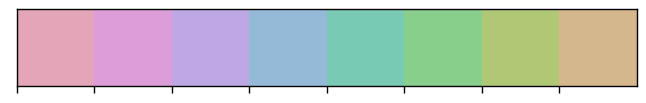

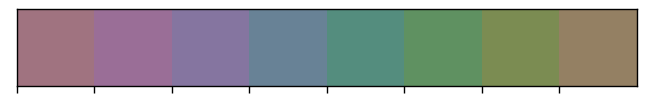

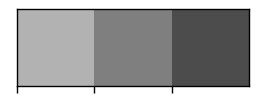

In [66]:
# Create 3 palettes with the logic:
# - use color palette when you plot different hues
# - use gray when you pool different hues, the intensities indicate noise level

# palettes for hues
from data_analysis.yml2dict import yml2dict
colorcode = yml2dict('data_analysis/rgb4plot.yaml')

# hue palette
palette = {k:colorcode[k] for k in [0, 45, 90, 135, 180, 225, 270, 315]} # can be used for 8 colors
sns.palplot(sns.color_palette(palette.values()))

# darker hue palette (e.g. use for higher noise):
palette_darker = {k:np.array(colorcode[k])* 0.7 for k in [0, 45, 90, 135, 180, 225, 270, 315]} 
sns.palplot(sns.color_palette(palette_darker.values()))

# palettes for noises when you pool hues, here shows 3 noise groups
noise_palette = np.array([[.7, .7, .7],[.5, .5, .5],[.3, .3, .3]])
sns.palplot(sns.color_palette(noise_palette))

In [67]:
# Define a function to connect circular data (e.g., duplicate data with ref=0 to data with ref=360)

def fill_gap(df):
    """
    Fill the gap to connect circular data (e.g., duplicate data with ref=0 to data with ref=360)
    """
    first = df.loc[df['ref'] == df['ref'].min()]
    first['ref'] = first['ref'].apply(lambda x: x + 360)


    last = df.loc[df['ref'] == df['ref'].max()]
    last['ref'] = last['ref'].apply(lambda x: x - 360)

    return pd.concat([df, first, last], ignore_index=False).sort_values('ref')

# 0.1 Subject colorspace fits

To have a quick look at the isoluminance measurements and the fits of isoluminant plane.

This part needs to be run only one time when for new subjects.

In [16]:
import json
def plot_isoslant(subject, save_path='data_analysis/isoslant/'):
    """
    Plot isoslant fitting and save the figure.

    :param subject:         subject name, for example 's0'
    :param subject_path:    directory where the isoslant file ('colorspace_s0.json') is stored

    """
    file_name = f"config/subjects/colorspace/10bit/colorspace_{subject}_10bit_20220414.json"
    with open(file_name, "r") as f:
        iso_slant = json.loads(json.load(f)['iso_slant'])

    a = iso_slant['amplitude']
    ph = iso_slant['phase']
    off = iso_slant['offset']

    xdata = np.array(iso_slant['xdata']) / np.pi * 180
    ydata = np.array(iso_slant['ydata'])

    x = np.arange(0., 360, .5)
    yfit = a * np.sin(x/180 * np.pi + ph) + off

    plt.figure(figsize=[10, 8])
    plt.scatter(xdata, ydata, marker= 'x', label='data', color='black')
    plt.plot(x, yfit, label='fit')
 
    if a > 0:
        x_peak = np.pi * .5 - ph
    else:
        x_peak = np.pi * 1.5 - ph
        
    x_peak = x_peak/np.pi * 180
    plt.vlines(x_peak, np.min(ydata), np.max(ydata), linestyles='dashed', colors='gray')
    # plt.grid()
    plt.legend()

    plt.xticks(np.append(np.unique(xdata), 360))
    plt.xlabel('Hue Angle \u03B8 (deg)')
    plt.ylabel('Delta Luminance contrast')
    plt.xlim([-5, 360])
    plt.annotate(f"peak \u03B8 = {np.round(x_peak, 2)}", xy=(x_peak*0.8, np.max(ydata)*1.05))
    plt.title(f"{subject} \n"
              f"dLum = {np.round(a, 3)} sin(\u03B8 [rad] + {np.round(ph, 3)}) + {np.round(off, 3)}")

    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
        print("Created new directory for saving path")
    plt.savefig(f"{save_path}isoslant_{subject}.pdf")
    
    plt.show()

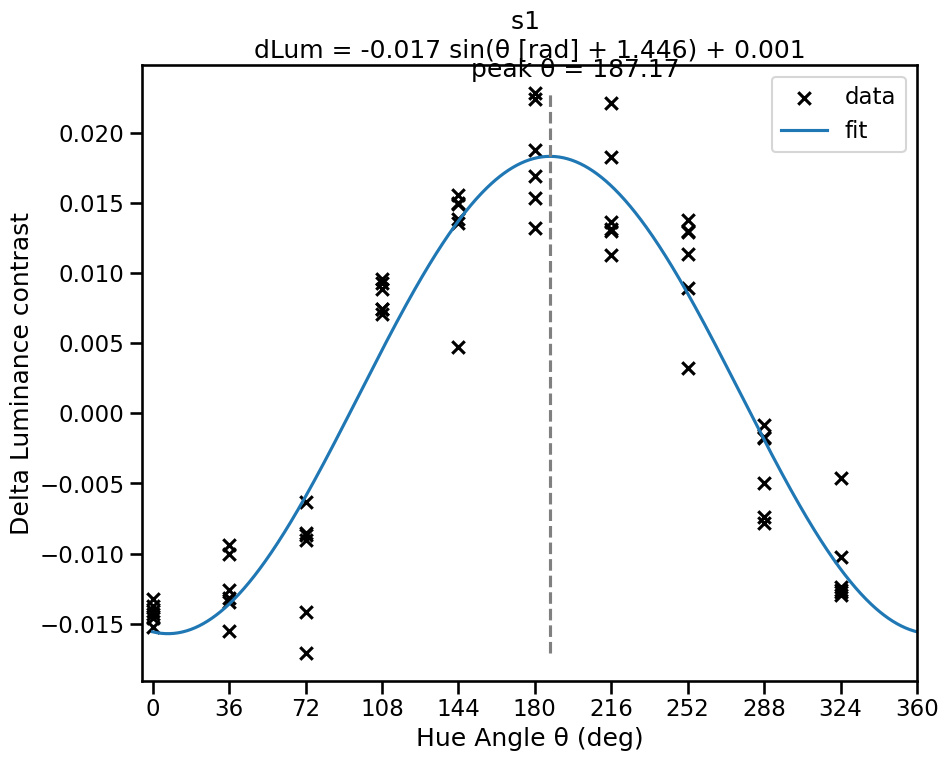

In [22]:
# Load subject colorspace and isoslant fits, save figures
plot_isoslant('s1', save_path='data_analysis/isoslant/')

# 1.1 Load Data

In [68]:
# Better to read data from csv

# all_dat = pd.read_csv('data/s1/s1.csv')
# all_dat = pd.read_csv('data/s5/s5.csv')
all_dat = pd.read_csv('data/all_data.csv')
# all_dat = pd.concat([pd.read_csv('data/all_data.csv'), pd.read_csv('data/s8/s8.csv')], ignore_index=True)

In [121]:
# all_dat = LoadData(sub='s8', data_path='data').read_data().query("noise in [0, 16]")

# all_dat = LoadData(sub='s5', data_path='data').read_data().query("noise in [0, 16]")
# all_dat.to_csv('data/s8/s8.csv', index=False)

In [202]:
# For s1, we need data cleaning

# remove extra 0noise trials and only choose noise=0 or 16
# all_dat = LoadData(sub='s1', data_path='data', sel_par=['mix', 'noise0'], rm_ses=['20220603T1720', '20220629T1837', '20220629T1843', '20220629T1848', '20220629T1853']).read_data().query("noise in [0, 16]")

# # save data
# all_dat.to_csv('data/s1/s1.csv', index=False)


In [203]:
# For s1 testing multiple noise levels...

# all_dat = all_dat[all_dat.block_index > '20220527T1024']  # noise 8 v. 16 for [0, 90, 180, 270]
# all_dat = all_dat.query("ref in [90, 270]")  # noise [6, 8, 12, 16] for [90, 270]

# pd.pivot_table(data=all_dat, values='relative_stimulus', index='ref', columns=['task_type', 'noise'],  aggfunc='count')


In [69]:
# use pivot to check the number of trials per condition per subject 
pd.pivot_table(data=all_dat, values='relative_stimulus', index='sub', columns=['task_type', 'noise'],  aggfunc='count')

task_type     3      
noise        0     16
sub                  
s1         1041  1048
s10        1040  1040
s3         1040  1040
s4         1040  1040
s5         1040  1040
s8         1040  1040
s9         1040  1040

In [7]:
# pilot =  pd.read_csv('pilot_data/pilot_all.csv').query("sub == 's1' and task_type == 3")

# pilot['relative_response'] = pilot['response'] - pilot['ref']

# all_dat = pd.concat([all_dat, pilot], ignore_index=True)

In [70]:
# Select the data `dat` you want to analyze from `all_dat`

# select single subject or all subjects (average)
# sub = 's3'
sub = 'sAvg' 

# create a analysis directory `dat_analysis/sub` if it hasn't been created
if not os.path.exists(os.path.dirname(f'data_analysis/{sub}/')):
        os.makedirs(os.path.dirname(f'data_analysis/{sub}/'))
        print("Created new directory for saving path")

if sub != 'sAvg':
    dat = all_dat[all_dat['sub'] == sub]
else:
    dat = all_dat

# select a specfic task_type or noise conditon
# dat = dat[dat.noise == 10]
# dat = dat[dat.task_type == 3]

In [71]:
# add more columns 
# discard trials with large errors
dat = dat.loc[dat['discard_this_trial']==False]

# `consistent` column represents whether judgment and reproduction are on the same left/right side
dat['consistent'] = False
dat.loc[(dat['right_to_ref']==0)&(dat['relative_response']<0),'consistent'] = True
dat.loc[(dat['right_to_ref']==1)&(dat['relative_response']>0),'consistent'] = True

# `abs_relative_stimulus` columns: absolute values of stimuli
dat['abs_relative_stimulus'] = dat.relative_stimulus.abs()

# `resp_correct` column represents whether responses are on the correct side
dat['resp_correct'] = True
dat.loc[dat.relative_stimulus * dat.relative_response < 0, 'resp_correct'] = False
dat.loc[(dat.relative_stimulus != 0) & (dat.relative_response == 0), 'resp_correct'] = False

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/2653955468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['consistent'] = False
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/2653955468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['abs_relative_stimulus'] = dat.relative_stimulus.abs()
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/2653955468.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [72]:
dat['sub'].unique()

array(['s1', 's4', 's3', 's5', 's10', 's9', 's8'], dtype=object)

In [11]:
# use pivot to check the number of trials per condition per subject 
pd.pivot_table(data=dat, values='response', index='relative_stimulus', columns=['task_type', 'noise', 'ref'],  aggfunc='count')

task_type           3                                                          \
noise              0                               16                           
ref               0   45  90  135 180 225 270 315 0   45  90  135 180 225 270   
relative_stimulus                                                               
-18                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
-15                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
-12                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
-9                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
-6                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
-3                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 0                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 3                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 6                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 9                 70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 12                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 15                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
 18                70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   

task_type              
noise                  
ref               315  
relative_stimulus      
-18                70  
-15                70  
-12                70  
-9                 70  
-6                 70  
-3                 70  
 0                 70  
 3                 70  
 6                 70  
 9                 70  
 12                70  
 15                70  
 18                70

In [8]:
# If you want exclude outliers with large bias...
# dat = dat[dat.relative_response <=28][dat.relative_response >= -28]

# 2.1 Psychometric function fitting

In [27]:
import psignifit as ps
import itertools

# to test, whether the installation works
# (it should display some lines and at the end say something like "5 passed")

# ps.test()


In [23]:
# used because error: Failed to process string with tex because latex could not be found
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_context('talk')  

def fit_judgment(sub, df_fit, fit_options, pool_ref, savepath):
    """
    Fit and plot psychometric functions.

    sub:            subject
    df_fit:         df_fit dataframe
    fit_options:    fitting options dictionary
    pool_ref:       whether to pool references
    savepath:       saving path ".../.../xxx.pdf"

    return 
    """
    if not os.path.exists(os.path.dirname(savepath)):
        os.makedirs(os.path.dirname(savepath))

    noises = df_fit.noise.unique()
    
    df_thr = pd.DataFrame(columns=["sub", "noise", "ref", "thr", "var"])


    if pool_ref is True:
        color_intens = np.linspace(1.4, 0.6, num=len(noises), endpoint=True)

        fig, ax = plt.subplots(figsize=(5, 5), nrows = 1, ncols=1)

        for n, c in zip(noises, color_intens):

            this_df_fit = df_fit[df_fit.noise == n]
            this_df_fit = this_df_fit[["relative_stimulus", "right_to_ref sum", "right_to_ref count"]]

            # convert to numpy array
            fit_data = this_df_fit.to_numpy().astype(float)

            # run fitting
            res = ps.psignifit(fit_data, fit_options)

            fit = res['Fit']
            thr_ci = res['conf_Intervals'][0]
            var_ci = res['conf_Intervals'][1]
            xDat = res['data'][:, 0]

            # we need to append the threshold dataframe
            # for this we can use append
            # "thr": 50% threshold; "var": slope parameter; represents percptual variability
            this_df_thr = {
                            "sub": sub,
                            "noise": n,
                            "ref": 'pooled',
                            "thr": fit[0],
                            "thr_ci": np.round(thr_ci, 3).flatten(),
                            'var': fit[1],
                            "var_ci": np.round(var_ci,3).flatten()
                        }
            df_thr = df_thr.append(this_df_thr, ignore_index=True)

            color = np.array([.5, .5, .5]) * c
            # plot data points
            ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, clip_on=False, color=color, label=f"noise = {n}")
            # plot fitted line
            xx = np.linspace(min(xDat), max(xDat), num=1000)
            fitValues = (1 - fit[2] - fit[3]) * res['options']['sigmoidHandle'](xx, fit[0], fit[1]) + fit[3]
            ax.plot(xx, fitValues, color=color)

            # plot horizontal and vertical dashed lines at the threshols
            thrY = fit[3] + (1 - fit[2] - fit[3]) * res['options']['threshPC']
            # ax.hlines(thrY, min(xDat), fit[0], linestyle='dashed', color=color)
            ax.vlines(fit[0], fit[3], thrY, linestyle='dashed', color=color)

            # plot errorbars
            ax.hlines(thrY, thr_ci[0], thr_ci[1], color=color)
            [ax.vlines(ci_x, thrY-0.015, thrY+0.015, color=color) for ci_x in thr_ci]  # as errorbar cap

        # set x and y ranges and labels
        xRange = [1.1*min(xDat) - .1*max(xDat), 1.1*max(xDat) - .1*min(xDat)]
        ax.set_xlim(xRange)
        ax.set_title(f"{sub}, pooled references")
        ax.set_xlabel('Stimulus Hue Angle Relative to Reference (deg)')
        ax.set_ylabel('Proportion of "Larger hue angle"')
        plt.legend()
        plt.savefig(savepath)
        plt.plot()


    # fit and plot for each reference
    if pool_ref is False:
        color_intens = np.linspace(1.1, 0.8, num=len(noises), endpoint=True)

        refs = df_fit['ref'].sort_values().unique()
        if len(refs) == 2:
            nrows = 1
            ncols = 2
        if len(refs) == 4:
            nrows = 1
            ncols = 4
        elif len(refs) == 8:
            ncols = 4
            nrows = 2

        fig, axes = plt.subplots(figsize=(ncols*5, nrows*5), nrows=nrows, ncols=ncols)

        # for ridx, ref in enumerate(refs):
        for idx, ax in enumerate(axes.flatten()):

            # filter data with this reference
            ref = refs[idx]

            for n, c in zip(noises, color_intens):
                this_df_fit = df_fit.loc[(df_fit["ref"] == ref) & (df_fit.noise == n)][["relative_stimulus", "right_to_ref sum", "right_to_ref count"]]
            # this_df_fit = df_fit.loc[(df_fit["ref"] == ref)][["relative_stimulus", "right_to_ref sum", "right_to_ref count"]]

                # convert to numpy array
                fit_data = this_df_fit.to_numpy().astype(float)

                # run fitting
                res = ps.psignifit(fit_data, fit_options)

                fit = res['Fit']
                thr_ci = res['conf_Intervals'][0]
                var_ci = res['conf_Intervals'][1]
                xDat = res['data'][:, 0]

                # we need to append the threshold dataframe
                # for this we can use append
                this_df_thr = {
                    "sub": sub,
                    "noise": n, 
                    "ref": ref,
                    "thr": np.round(fit[0],3),
                    "thr_ci": np.round(thr_ci, 3).flatten(),
                    'var': np.round(fit[1], 3),
                    "var_ci": np.round(var_ci,3).flatten()
                }
                df_thr = df_thr.append(this_df_thr, ignore_index=True)

                color = np.array(colorcode[ref]) * c
                # color = colorcode[ref]

                # plot data points
                ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
                # plot fitted line
                xx = np.linspace(min(xDat), max(xDat), num=1000)
                fitValues = (1 - fit[2] - fit[3]) * res['options']['sigmoidHandle'](xx, fit[0], fit[1]) + fit[3]
                ax.plot(xx, fitValues, color=color)

                # plot horizontal and vertical dashed lines at the threshols
                thrY = fit[3] + (1 - fit[2] - fit[3]) * res['options']['threshPC']
                # ax.hlines(thrY, min(xDat), fit[0], linestyle='dashed', color=color)
                ax.vlines(fit[0], fit[3], thrY, linestyle='dashed', color=color)

                # plot errorbars
                ax.hlines(thrY, thr_ci[0], thr_ci[1], color=color)
                [ax.vlines(ci_x, thrY-0.015, thrY+0.015, color=color) for ci_x in thr_ci]  

                # set x and y ranges and labels
                xRange = [1.1*min(xDat) - .1*max(xDat), 1.1*max(xDat) - .1*min(xDat)]
                ax.set_xlim(xRange)
                ax.set_title(f"sub:{sub}, ref: {ref}")
                ax.set_xlabel('Stimulus Hue Angle Relative to Reference (deg)')
                ax.set_ylabel('Proportion of "Larger hue angle"')
                
        plt.legend()
        plt.savefig(savepath)
        plt.plot()


    return df_thr

In [24]:
# define fitting options

fit_options = {'sigmoidName': 'norm', 'expType': 'YesNo'}
fit_options['fixedPars'] = np.ones([5, 1]) * np.nan

# threshold
# fit_options['fixedPars'][0] = 0.
# lapse rate
# fit_options['fixedPars'][2] = 0.
# lower guessing rate
# fit_options['fixedPars'][3] = 0.
# eta factor -> cf. psignifit documentation
# fit_options['fixedPars'][4] = 0.

# confidential interval of estimates -> decide the length of errorbars
fit_options['confP'] = [.68]  # or [.95]

In [25]:
# count the total number of judgment trials and the number of trials with responses "the stimulus show larger hue angle (right side to the reference)"
df_fit = dat.groupby(["sub", "ref", "relative_stimulus", "noise"])[["right_to_ref"]]\
        .agg(["sum", "count"]).reset_index()
df_fit.columns = [' '.join(col).strip() for col in df_fit.columns.values]

# compute the proportion/percent of responses as "the stimulus show larger hue angle"
df_fit["right_to_ref p"] = df_fit["right_to_ref sum"]/df_fit["right_to_ref count"]*100.

df_fit.head()

sub  ref  relative_stimulus  noise  right_to_ref sum  right_to_ref count  \
0  s1    0                -18      0                 0                  10   
1  s1    0                -18     16                 0                  10   
2  s1    0                -15      0                 0                  10   
3  s1    0                -15     16                 0                  10   
4  s1    0                -12      0                 0                  10   

   right_to_ref p  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/likelihood.py:191: RuntimeWarning: divide by zero encountered in log
  pbin = pbin  + (ni-ki)*np.log(1-psi)


(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_72477/709933893.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance o

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_72477/709933893.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, clip_on=False, color=color, label=f"noise = {n}")


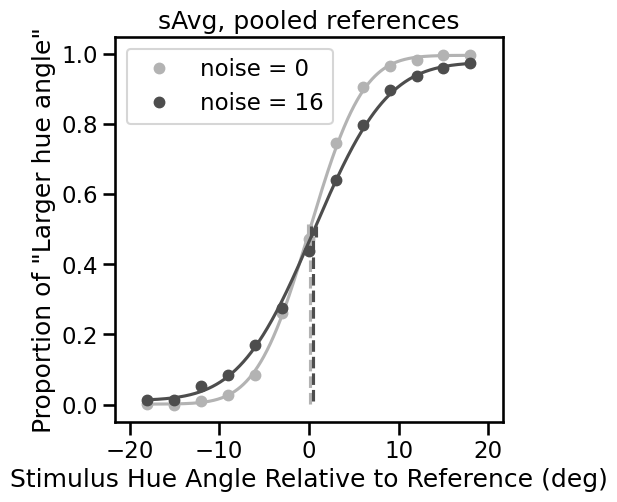

In [28]:
# Fit for pooled references by `pool_ref=True`
df_thr = fit_judgment(sub, df_fit, fit_options, pool_ref=True, savepath=f'data_analysis/{sub}/judge.pdf')
df_thr.to_csv(f"data_analysis/{sub}/judge_pars.csv", index=False)

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/likelihood.py:191: RuntimeWarning: divide by zero encountered in log
  pbin = pbin  + (ni-ki)*np.log(1-psi)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argume

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")


(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/likelihood.py:121: RuntimeWarning: divide by zero encountered in log
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/likelihood.py:121: RuntimeWarning: invalid value encountered in multiply
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/psignifit/likelihood.py:127: RuntimeWarning: invalid value encountered in subtract
  p = p -

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")
/home/yannan/anaconda

(array([], dtype=int64),)


/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/tmp/ipykernel_9539/1395031190.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_thr = df_thr.append(this_df_thr, ignore_index=True)
/tmp/ipykernel_9539/1395031190.py:144: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(res['data'][:,0], res['data'][:,1]/res['data'][:,2], '.k', ms=15, alpha=0.8, clip_on=False, color=color, label=f"noise = {n}")


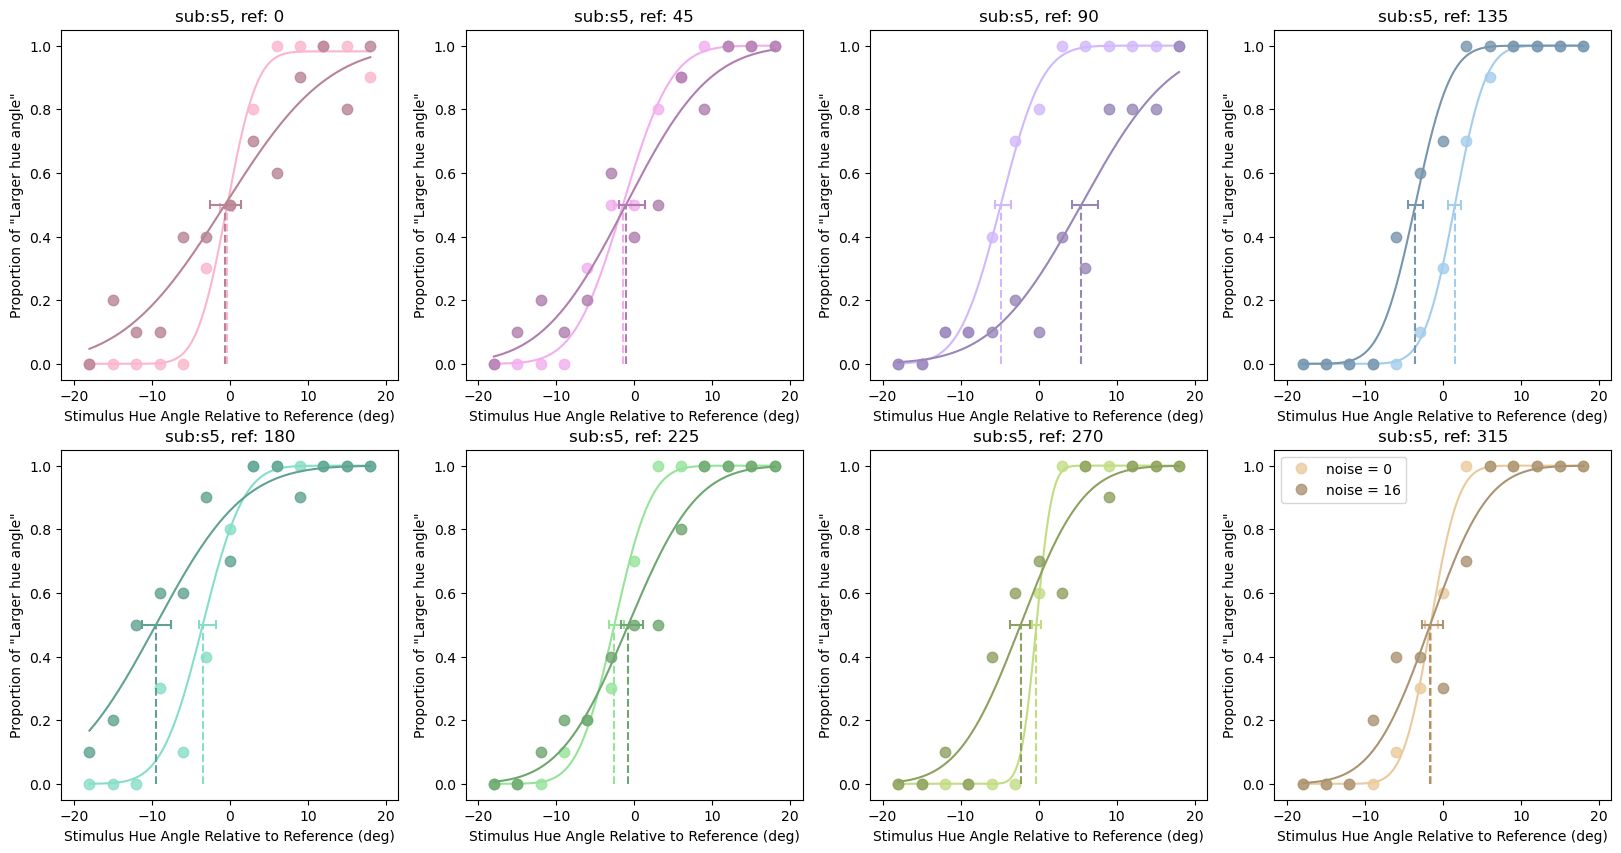

In [108]:
# Fit for each reference by `pool_ref=False`
df_thr_by_ref = fit_judgment(sub, df_fit, fit_options, pool_ref=False, savepath=f'data_analysis/{sub}/judge_by_ref.pdf')
df_thr_by_ref.to_csv(f"data_analysis/{sub}/judge_pars_by_ref.csv", index=False)


In [120]:
# Discrimiantion thresholds across colors, for each subjects

# judge_pars = pd.concat([pd.read_csv(f"data_analysis/csv/{s}_judge_pars_by_ref.csv") for s in dat['sub'].unique()], ignore_index=True)
# judge_pars['var_ci'] = judge_pars['var_ci'].apply(lambda x: list(map(float, list(filter(None, x[1:-1].replace(" ", ",").split(','))))))
# judge_pars['thr_ci'] = judge_pars['thr_ci'].apply(lambda x: list(map(float, list(filter(None, x[1:-1].replace(" ", ",").split(','))))))
# judge_pars.to_csv("data_analysis/csv/allsub_judge_pars_by_ref.csv", index=False)

# judge_pars = pd.read_csv("data_analysis/csv/allsub_judge_pars_by_ref.csv")
# # judge_pars['var_err'] = judge_pars['var_ci']
# g = sns.relplot(data=fill_gap(judge_pars).sort_values(by='sub').reset_index(), x='ref', y='var', hue='noise', col='sub', facet_kws={'sharey': False, 'sharex': True}, 
#                 kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette= sns.color_palette(noise_palette[0:2]), zorder=3)
# g.map(plt.errorbar, 'ref', 'var', 'var_ci', linestyle='None', capsize=5, color='gray', zorder=2)


# 2.2 Correctness of judge

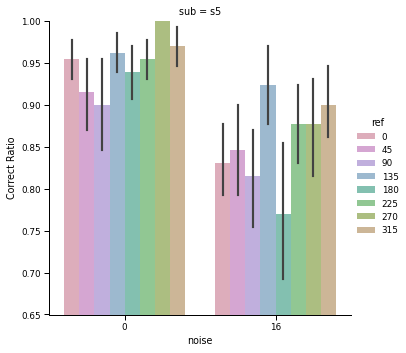

In [82]:
count_correct = dat.groupby(['sub', 'noise', 'ref', 'relative_stimulus'])['ref_judge_correct'].agg(['count', 'sum']).reset_index()
count_correct['correctness_ratio'] = count_correct['sum']/count_correct['count']

g = sns.catplot(data=count_correct, x='noise',y='correctness_ratio', col='sub', hue='ref', palette=palette, kind='bar', ci=68)
g.set(ylim=[0.65, 1.0], ylabel='Correct Ratio')
# plt.savefig(f'data_analysis/{sub}/{sub}_correct_ratio.pdf')

# 3.1 Distribution Plot & Stats

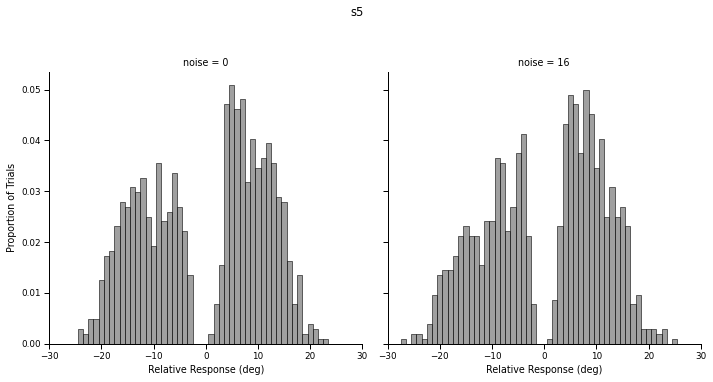

In [106]:
# plot estimates distribution, col=conditions

# (default) 'stat' = 'count' = > ylabel='Number of Trials'
# 'stat' = 'percent' => ylabel='Proportion of Trials'

ax = sns.displot(data=dat,x='relative_response', binwidth=1, col='noise', color='gray', 
                stat='proportion', common_norm=False, discrete=True)  # col='task_type' or 'noise'
ax.set(xlabel='Relative Response (deg)', ylabel='Proportion of Trials', xlim=[-30, 30])
plt.suptitle(sub, y=1.05)
plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_estimate_dist.pdf')

In [164]:
# dip-test on multimodality, with null hypothesis: the distribution is a unimodal distribution
# https://pypi.org/project/diptest/

import diptest
# basic usage: 
# dip, pval = diptest.diptest(xx)

print(f"For all data, the probability to accept that the distribution is unimodal: {diptest.diptest(dat['relative_response'].values)[1]}")
print(f"When noise is 0, the probability to accept that the distribution is unimodal: {diptest.diptest(dat[dat.noise==0]['relative_response'].values)[1]}")
print(f"When noise is 16, the probability to accept that the distribution is unimodal: {diptest.diptest(dat[dat.noise==16]['relative_response'].values)[1]}")

For all data, the probability to accept that the distribution is unimodal: 0.0
When noise is 0, the probability to accept that the distribution is unimodal: 0.0
When noise is 16, the probability to accept that the distribution is unimodal: 0.0


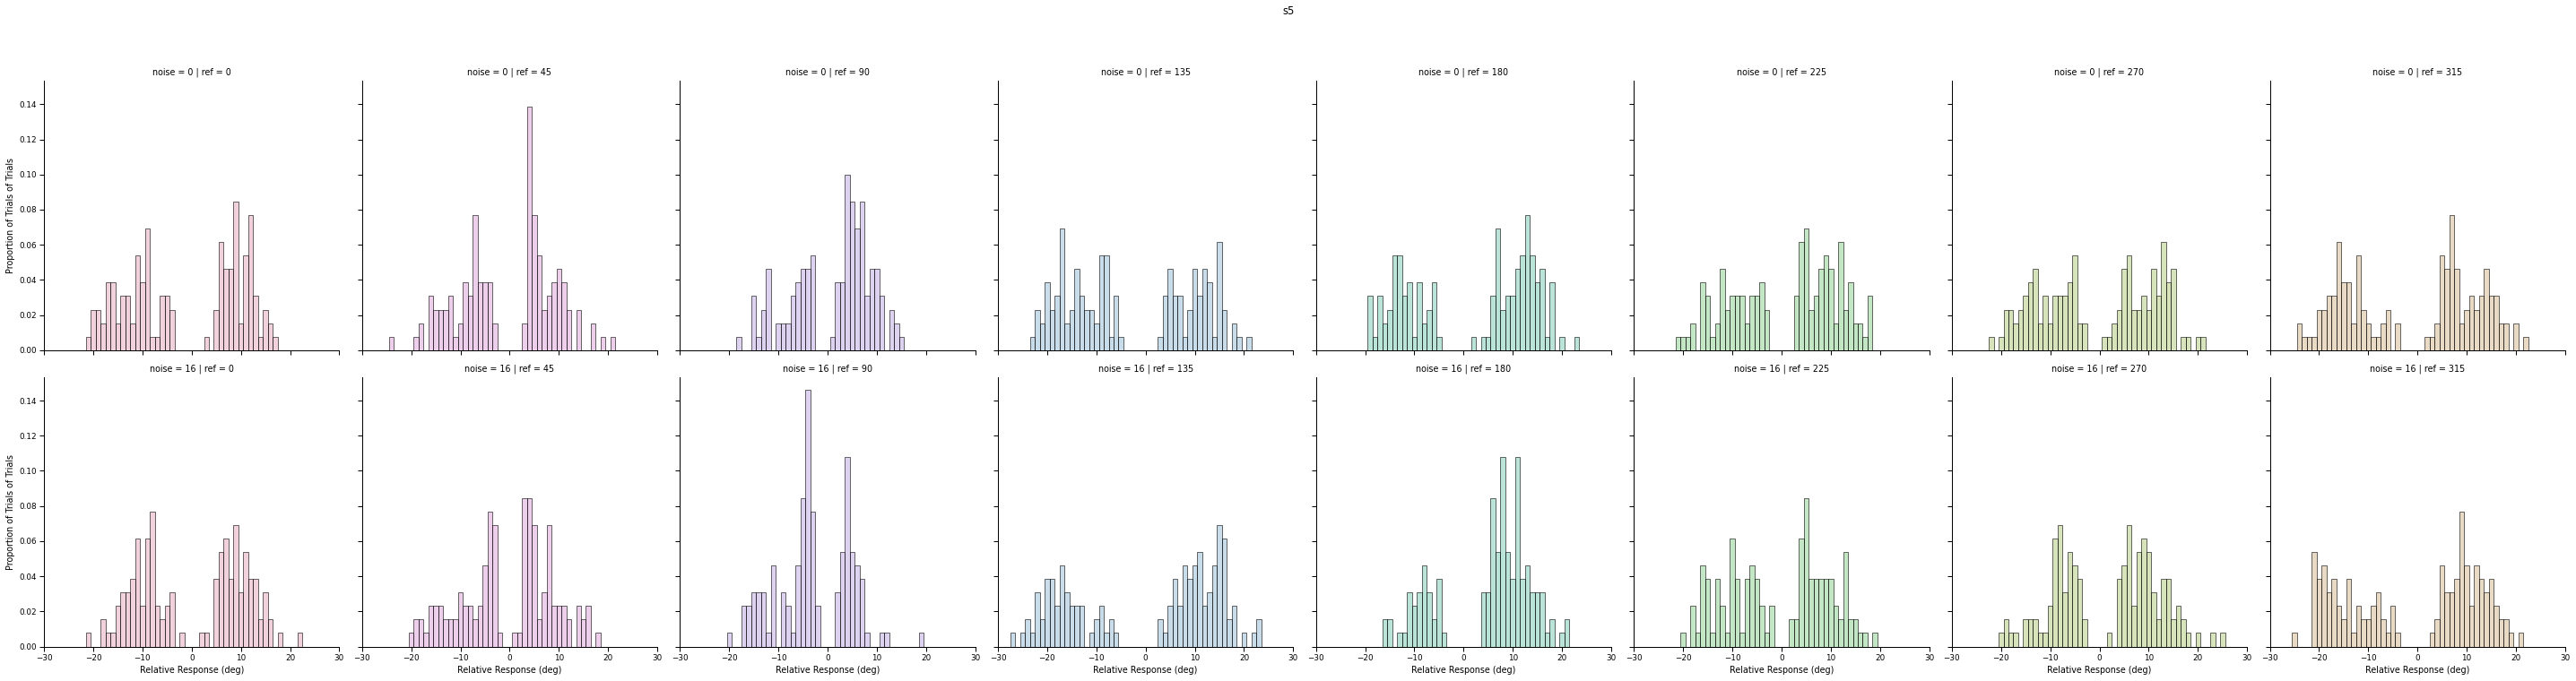

In [105]:
# plot estimates distribution, col=references, row=conditions

# ax = sns.displot(data=dat,x='relative_response', binwidth=1, col ='ref', row='noise', hue='ref', palette=palette, legend=False)
# ax.set(xlabel='Relative Response (deg)', ylabel='Number of Trials', xlim=[-30, 30])

ax = sns.displot(data=dat,x='relative_response', binwidth=1, col ='ref', row='noise', hue='ref', palette=palette, legend=False, 
                stat='proportion', common_norm=False, discrete=True) 
ax.set(xlabel='Relative Response (deg)', ylabel='Proportion of Trials of Trials', xlim=[-30, 30])
plt.suptitle(sub, y=1.05)

plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_estimate_dist_by_ref.pdf')


# 3.2 Scatter Plot

Not in use

In [ ]:
# b = sns.relplot(data=dat, x='relative_stimulus', y='relative_response', col='task_type') # col='task_type' or 'noise'
# ax = b.fig.axes
# [axi.plot(np.linspace(-20, 20, 100, endpoint=True), np.linspace(-20, 20, 100, endpoint=True), color='gray', linestyle='--') for axi in ax]
# b.set_ylabels("Relative Response (deg)")
# b.set_xlabels("Relative Stimulus (deg)")
# plt.suptitle(sub, y=1.05)

# plt.tight_layout()
# #plt.savefig('pilot_figures/combined/combined_fig2.1_allref.pdf')

In [ ]:
# g = sns.relplot(data=dat, x='relative_stimulus', y='relative_response',col='ref', row='noise') # row='task_type' or 'noise'
# plt.suptitle(sub, y=1.05)
# ax = g.fig.axes
# [axi.plot(np.linspace(-20, 20, 100, endpoint=True), np.linspace(-20, 20, 100, endpoint=True), color='gray', linestyle='--') for axi in ax]

# g.set_ylabels("Relative Response (deg)")
# g.set_xlabels("Relative Stimulus (deg)")

# plt.tight_layout()
# #plt.savefig('pilot_figures/combined/combined_fig2.pdf')

# 3.2 Distribution Heatmap

[]

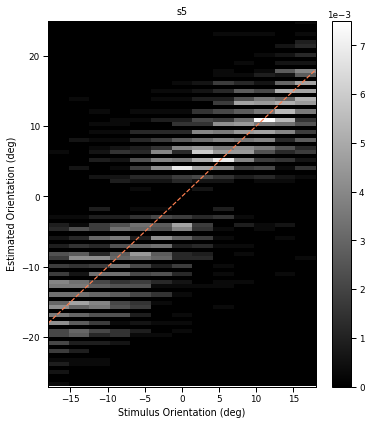

In [107]:
# Heatmap for pooled reference data

n_stim = len(dat['relative_stimulus'].unique())

# create a new figure
fig, ax = plt.subplots(1, 1, figsize=(5.5, 6))

# bin data for 2d histogram
hh, xedges, yedges = np.histogram2d(dat.relative_stimulus.values, dat.relative_response.values, bins=[n_stim, 90], normed=True)

# plot with colorbar
im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
cb = fig.colorbar(im, ax=ax)
cb.formatter.set_powerlimits((0, 0))

# plot y=x dashed lin
ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
# sns.lineplot(ax=ax, data=dat, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')

# add labels
ax.set_title(sub)
ax.set_xlabel('Stimulus Orientation (deg)')
ax.set_ylabel('Estimated Orientation (deg)')

plt.tight_layout()

plt.savefig(f'data_analysis/{sub}/{sub}_heatmap.pdf')
plt.plot()

[]

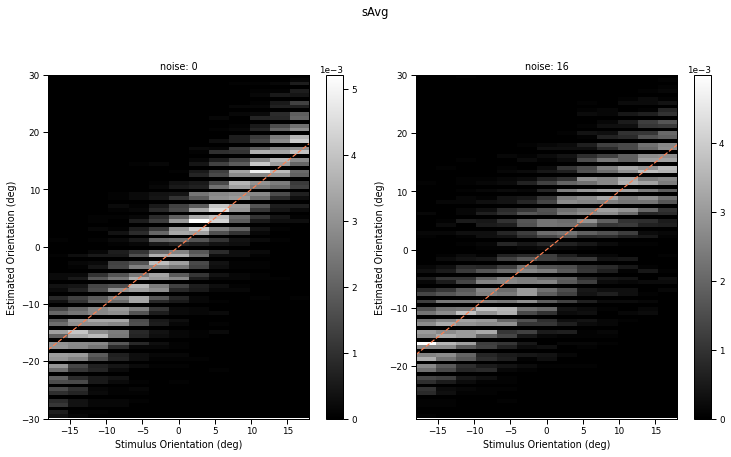

In [166]:
# for different noise conditions

n_stim = len(dat['relative_stimulus'].unique())
noises = dat['noise'].sort_values().unique()


fig, axes = plt.subplots(1, len(noises), figsize=[5*len(noises) + 0.5, 6*1])

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    noise = noises[idx]
    vals = dat[dat.noise==noise]
    hh, xedges, yedges = np.histogram2d(vals.relative_stimulus.values, vals.relative_response.values, bins=[n_stim, 90], normed=True)
    im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
    cb = fig.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))

    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
    # sns.lineplot(ax=ax, data=vals, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')
    ax.set_title(f"noise: {noise}")
    ax.set_xlabel('Stimulus Orientation (deg)')
    ax.set_ylabel('Estimated Orientation (deg)')
    plt.suptitle(sub, y=1.05)

plt.tight_layout()

# plt.savefig(f'data_analysis/{sub}/{sub}_heatmap_by_noise.pdf')
plt.plot()

/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==0]
/tmp/ipykernel_5947/15814211.py:18: UserWarning: Boolean Series key will be reinde

[]

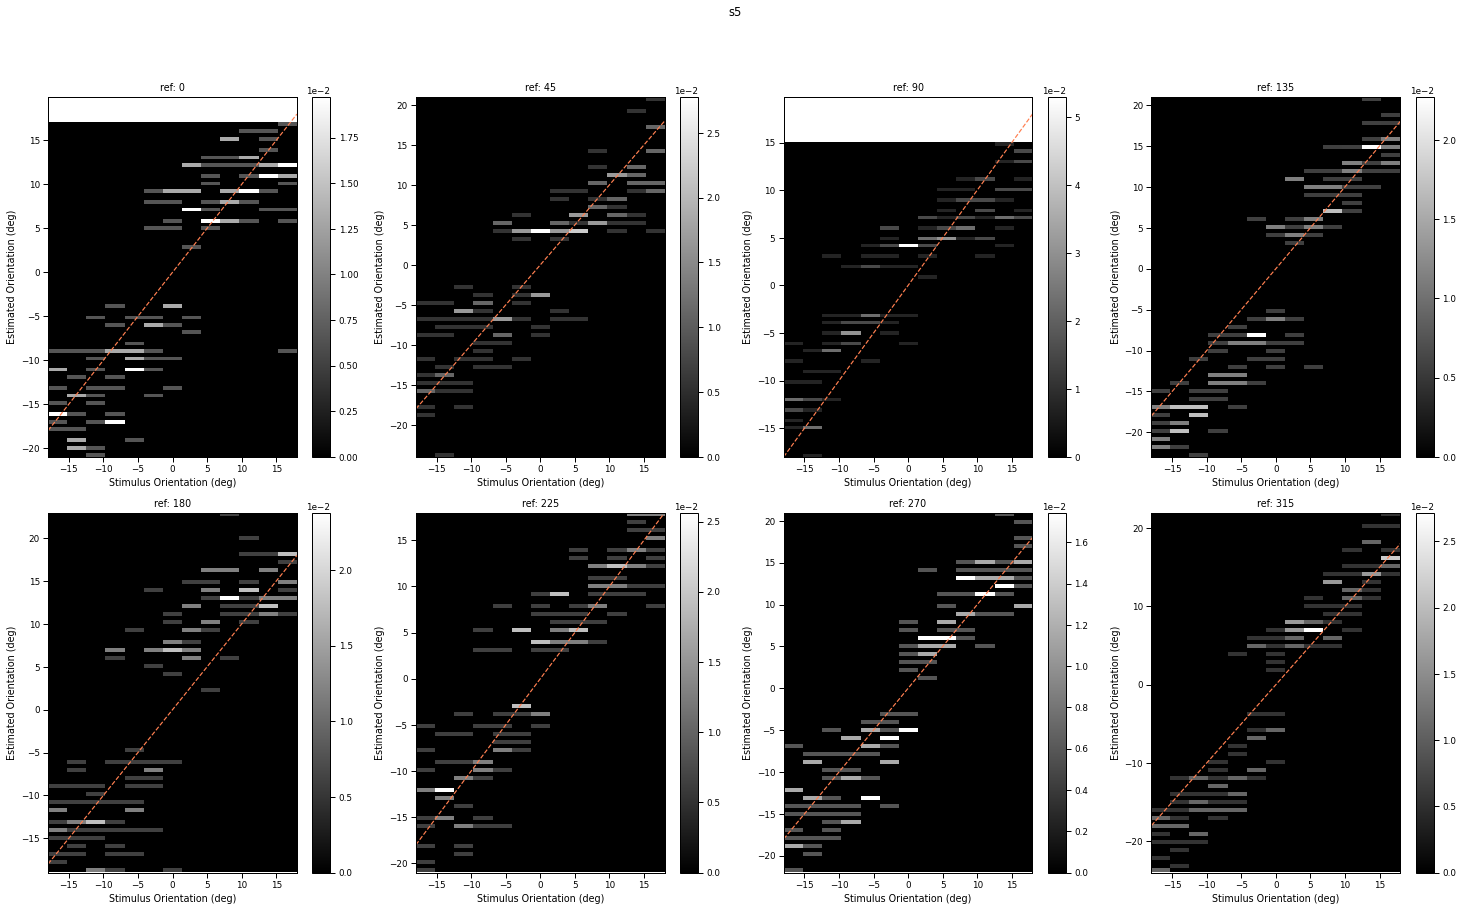

In [109]:
# for different refs

n_stim = len(dat['relative_stimulus'].unique())
refs = dat['ref'].sort_values().unique()

if len(refs) <= 4:
    nrows = 1
    ncols = len(refs)
elif len(refs) == 8:
    ncols = 4
    nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=[5*ncols + 0.5, 6*nrows])

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    ref = refs[idx]
    vals = dat[dat.ref==ref][dat.noise==0]
    hh, xedges, yedges = np.histogram2d(vals.relative_stimulus.values, vals.relative_response.values, bins=[n_stim, 90], normed=True)
    im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
    cb = fig.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))

    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
    # sns.lineplot(ax=ax, data=vals, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')
    ax.set_title(f"ref: {ref}")
    ax.set_xlabel('Stimulus Orientation (deg)')
    ax.set_ylabel('Estimated Orientation (deg)')
    plt.suptitle(sub, y=1.05)

plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_heatmap_by_ref_noise0.pdf')
plt.plot()

/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = dat[dat.ref==ref][dat.noise==16]
/tmp/ipykernel_5947/1825981780.py:16: UserWarning: Boolean Serie

[]

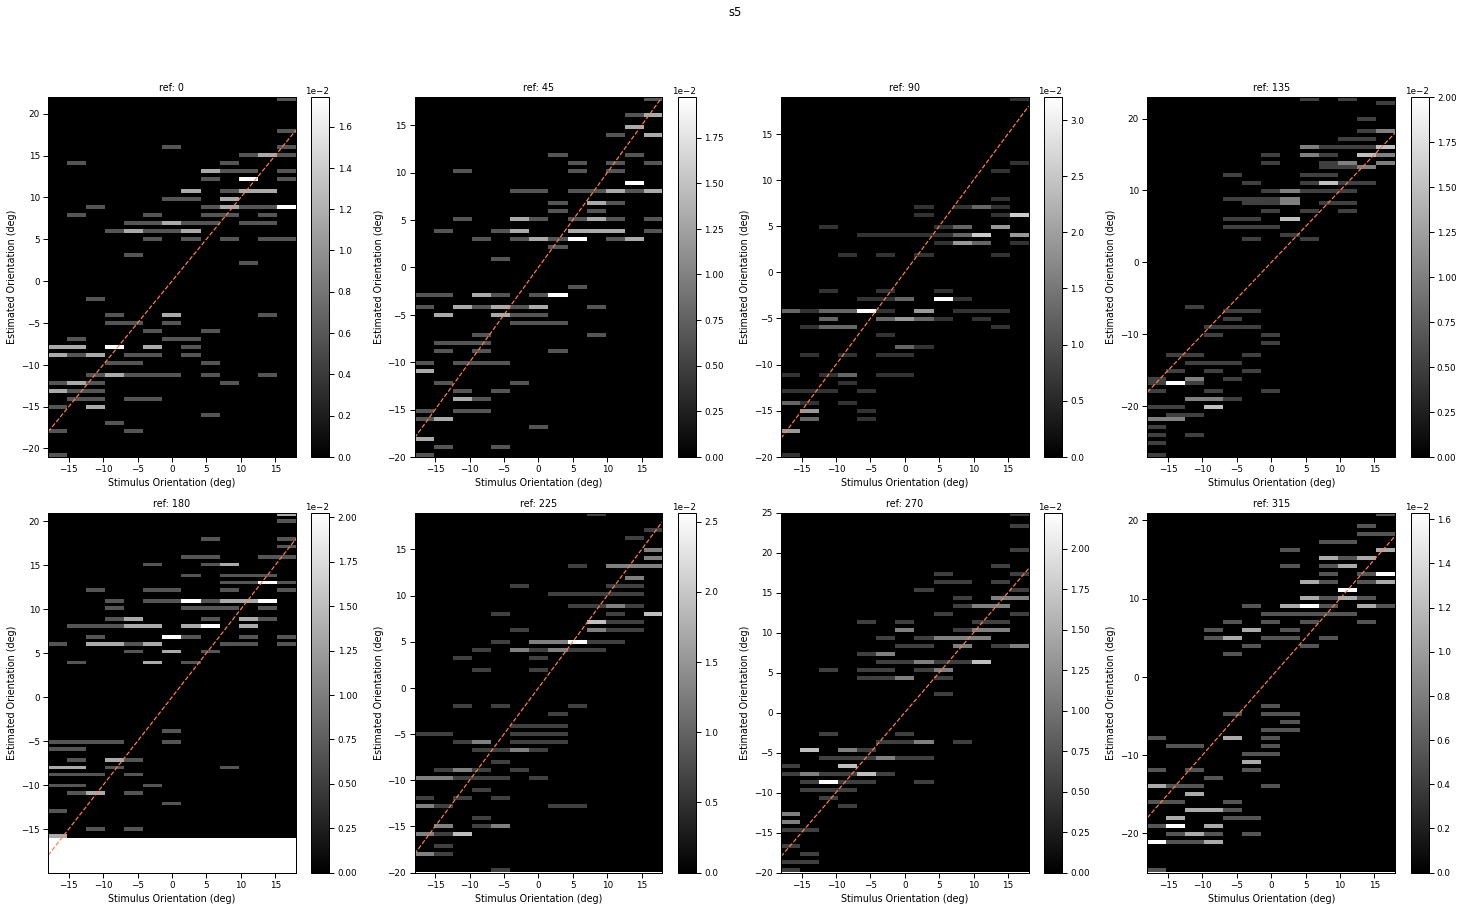

In [110]:
n_stim = len(dat['relative_stimulus'].unique())
refs = dat['ref'].sort_values().unique()

if len(refs) <= 4:
    nrows = 1
    ncols = len(refs)
elif len(refs) == 8:
    ncols = 4
    nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=[5*ncols + 0.5, 6*nrows])

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    ref = refs[idx]
    vals = dat[dat.ref==ref][dat.noise==16]
    hh, xedges, yedges = np.histogram2d(vals.relative_stimulus.values, vals.relative_response.values, bins=[n_stim, 90], normed=True)
    im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
    cb = fig.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))

    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
    # sns.lineplot(ax=ax, data=vals, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')
    ax.set_title(f"ref: {ref}")
    ax.set_xlabel('Stimulus Orientation (deg)')
    ax.set_ylabel('Estimated Orientation (deg)')
    plt.suptitle(sub, y=1.05)

plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_heatmap_by_ref_noise16.pdf')

plt.plot()

# 3.3 Estimates Means

[]

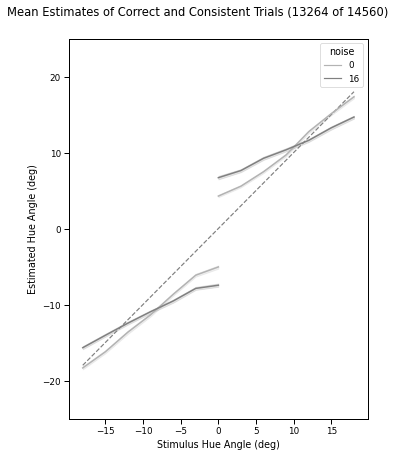

In [190]:
dat_correct_consistent = dat[(dat.ref_judge_correct == 1) & (dat.consistent == 1)]

fig, ax = plt.subplots(figsize=(5, 6), )

# You can set hue here
hue = 'noise'
# hue = 'ref'
# hue = 'sub'

if hue == 'noise':
    pl = sns.color_palette(noise_palette[0:2])
elif hue == 'ref':
    pl = palette
else:
    pl = 'pastel'

ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='gray')
sns.lineplot(data=dat_correct_consistent.query("relative_response >= 0"),
            x='relative_stimulus', y='relative_response', hue=hue, linewidth=1.5, ci=68, ax=ax, palette=pl)
sns.lineplot(data=dat_correct_consistent.query("relative_response <= 0"),
                x='relative_stimulus', y='relative_response', hue=hue, linewidth=1.5, ci=68, ax=ax, palette=pl, legend=False)
ax.set_ylim([-25, 25])
ax.set_xlabel('Stimulus Hue Angle (deg)')
ax.set_ylabel('Estimated Hue Angle (deg)')

plt.tight_layout()
plt.suptitle(f"Mean Estimates of Correct and Consistent Trials ({len(dat_correct_consistent)} of {len(dat)})", x=0.5, y=1.05)

# plt.savefig(f'data_analysis/{sub}/estimates_mean_by_noise.pdf')

plt.plot()

# 3.4 Heatmap + Estimates Means

Combine 3.2 and 3.3, note that the estimate means are still of correct and consistent trials.

[]

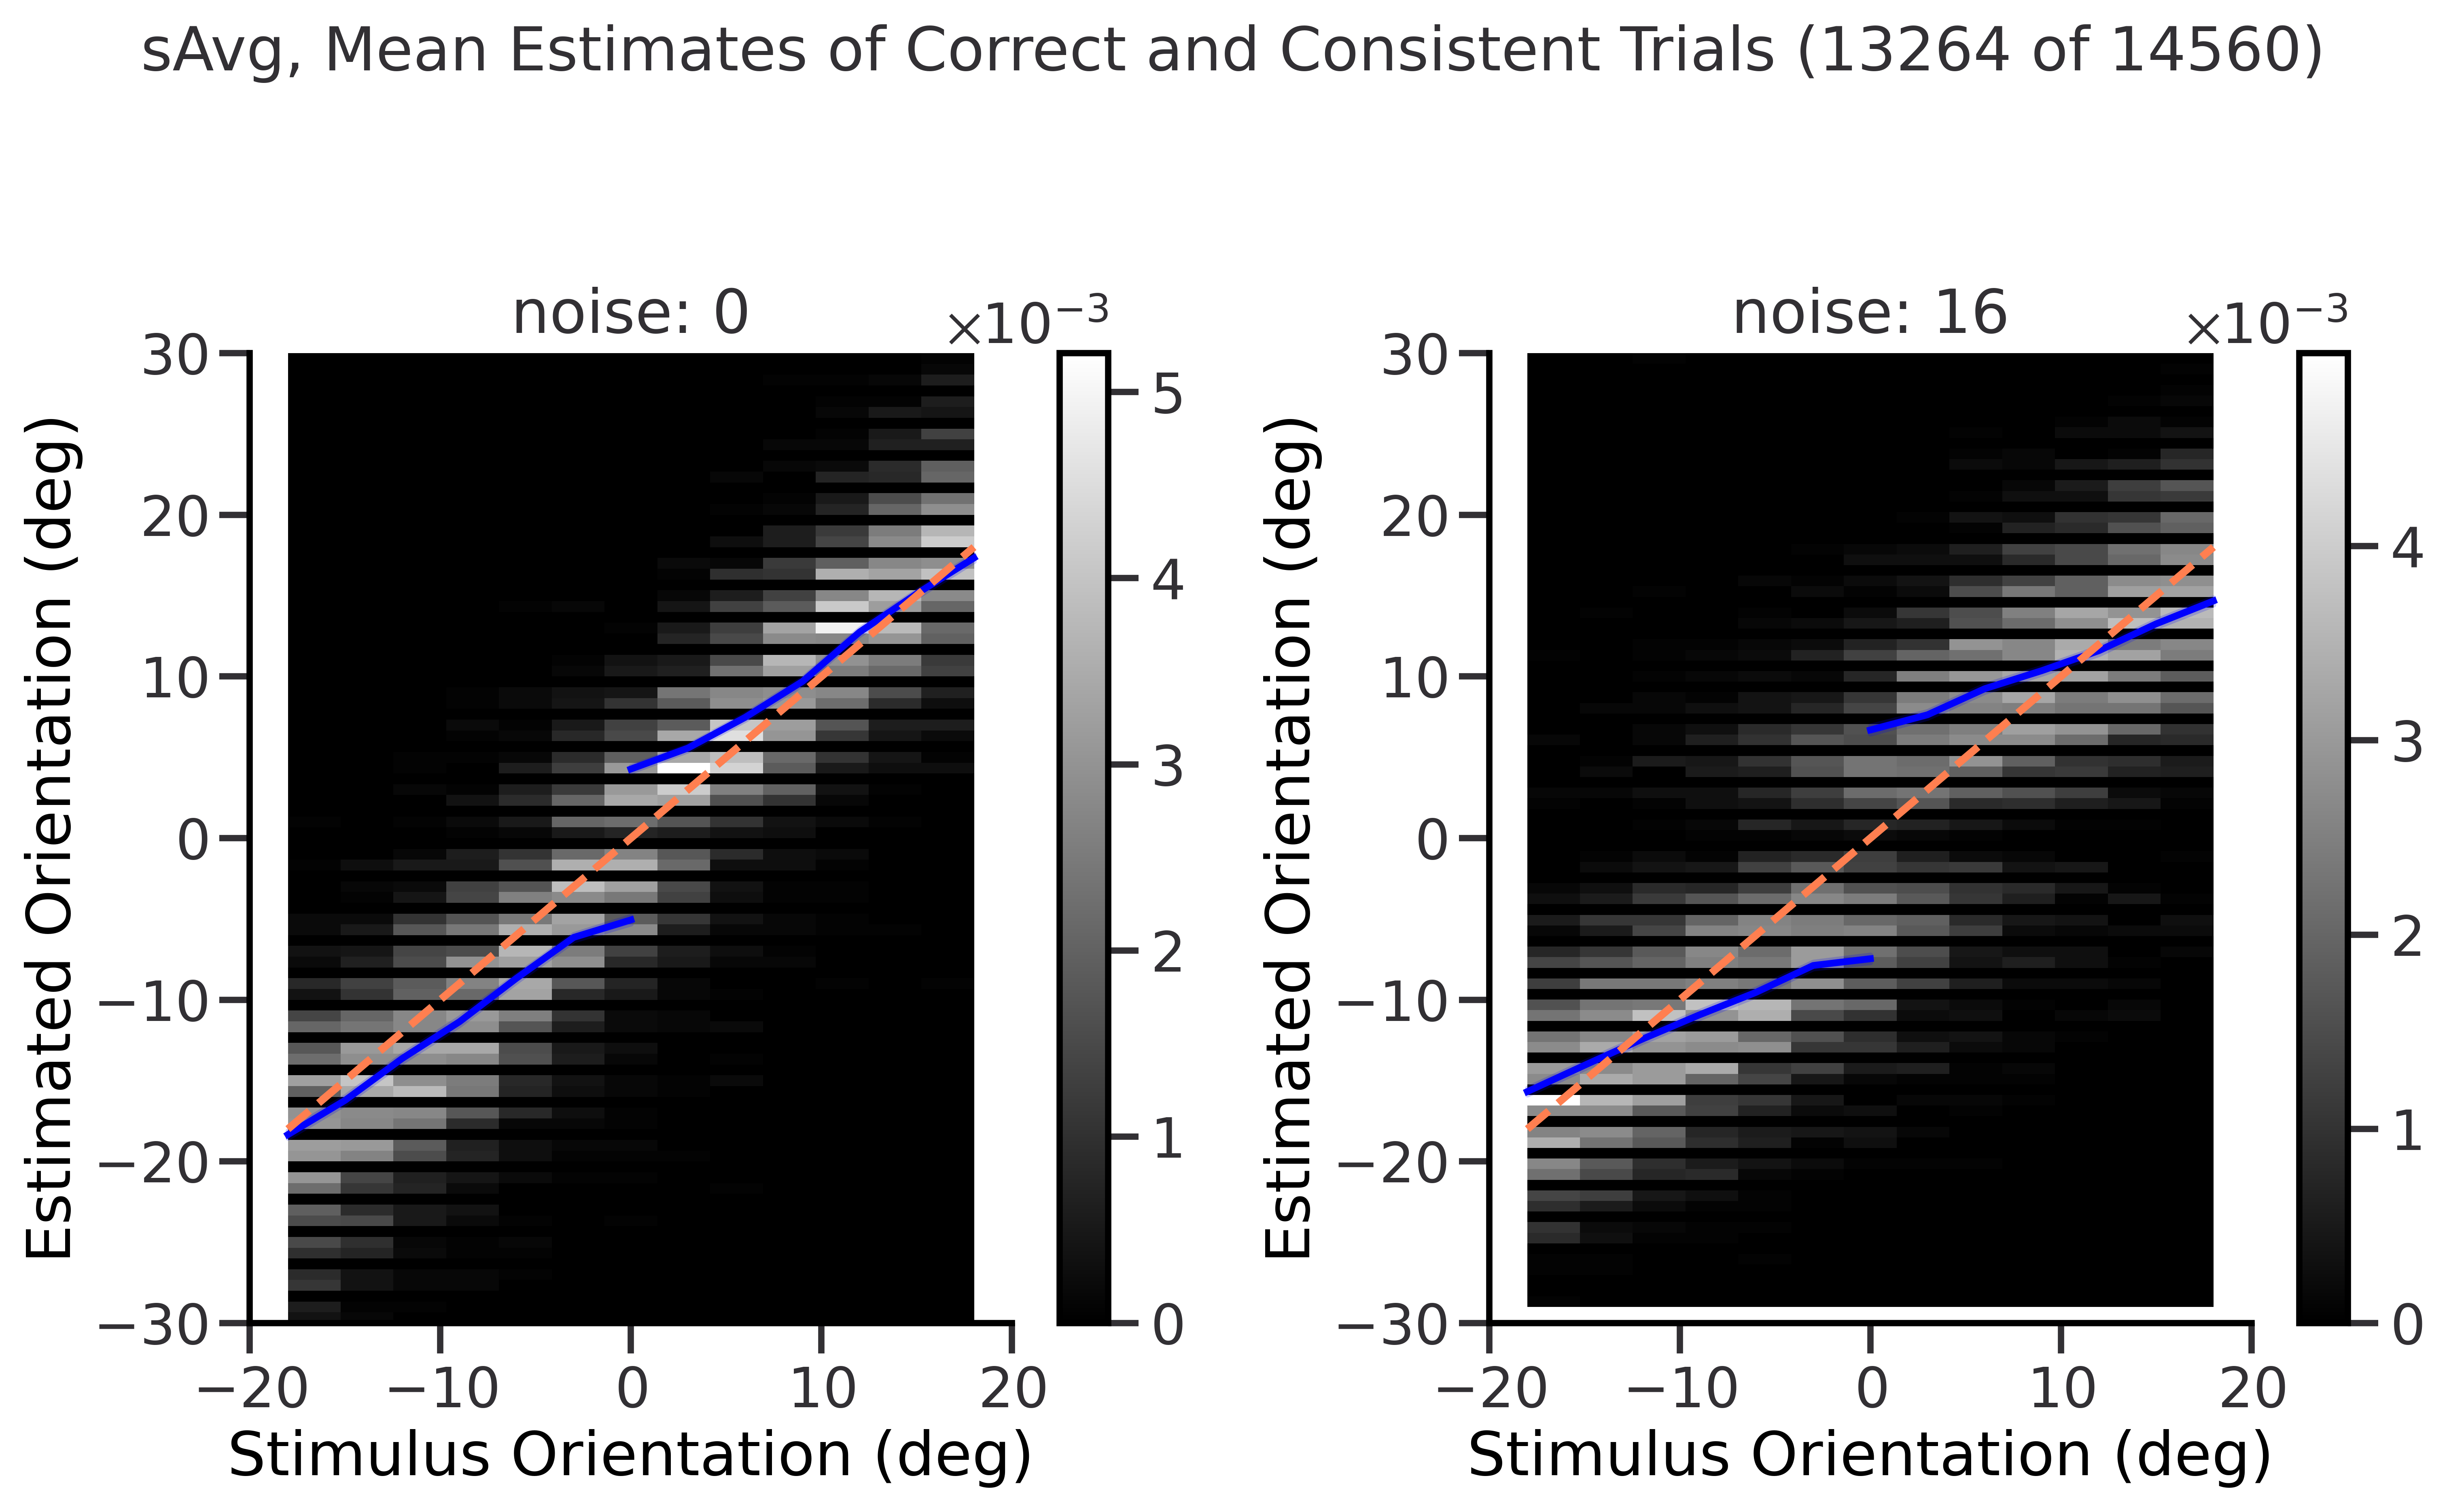

In [15]:

n_stim = len(dat['relative_stimulus'].unique())
noises = dat['noise'].sort_values().unique()

dat_correct_consistent = dat[(dat.ref_judge_correct == 1) & (dat.consistent == 1)]

fig, axes = plt.subplots(1, len(noises), figsize=[5*len(noises) + 0.5, 6*1])

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    noise = noises[idx]
    vals = dat[dat.noise==noise]
    hh, xedges, yedges = np.histogram2d(vals.relative_stimulus.values, vals.relative_response.values, bins=[n_stim, 90], normed=True)
    im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
    cb = fig.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))
    
    sel_dat_correct_consistent = dat_correct_consistent[dat_correct_consistent.noise==noise]
    
    sns.lineplot(data=sel_dat_correct_consistent.query("relative_response >= 0"),
            x='relative_stimulus', y='relative_response', linewidth=2., ci=68, ax=ax, color='blue')
    sns.lineplot(data=sel_dat_correct_consistent.query("relative_response <= 0"),
                x='relative_stimulus', y='relative_response', linewidth=2., ci=68, ax=ax, color='blue')
                
    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
    # sns.lineplot(ax=ax, data=vals, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')
    ax.set_title(f"noise: {noise}")
    ax.set_xlabel('Stimulus Orientation (deg)')
    ax.set_ylabel('Estimated Orientation (deg)')

plt.suptitle(f"{sub}, Mean Estimates of Correct and Consistent Trials ({len(dat_correct_consistent)} of {len(dat)})", x=0.5, y=1.05)
plt.tight_layout()

# plt.savefig(f'data_analysis/{sub}/{sub}_heatmap+mean_by_noise.pdf')
plt.plot()


# 4.0 Repulsive Bias (two-side combined)

In [15]:
# create repulsive bias data dataframe before doing any plotting or modeling

# compute repulsive bias
dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))

# select correct ones
dat_correct = dat[dat.ref_judge_correct == 1].sort_values(by=['noise', 'ref'])

/tmp/ipykernel_12999/3750768331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))


## 4.1 Plots with seaborn

Text(0.5, 1.05, 'Repulsive Bias of Correct Trials (13330 of 14560)')

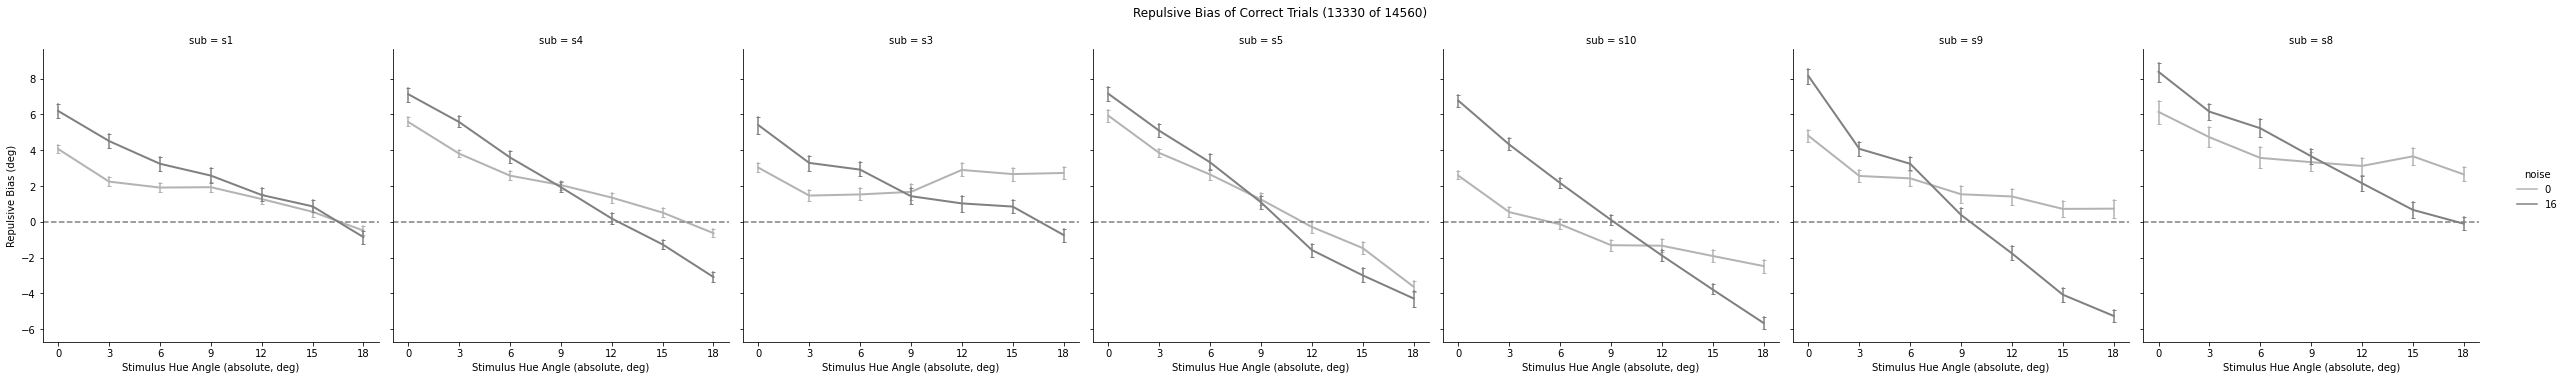

In [14]:
# plot repulsive bias: pool refrence hues

# col = 'sub' or 'noise' or 'task_type'

# You can set hue here
hue = 'noise'
# hue = 'sub'

if hue == 'noise':
    pl = sns.color_palette(noise_palette[0:2])
else:
    pl = 'pastel'

g = sns.relplot(data=dat_correct, x='abs_relative_stimulus', y='repulsive_bias', hue=hue, col='sub', 
                facet_kws={'sharey': True, 'sharex': True},
                kind='line', linewidth=2, ci=68, err_style="bars", err_kws={'capsize': 2.}, palette=pl)

g.map(plt.axhline, y=0, color='gray', linestyle='dashed')
g.set(xlabel='Stimulus Hue Angle (absolute, deg)', ylabel='Repulsive Bias (deg)')
g.set(xticks=dat.abs_relative_stimulus.unique().astype(float))

plt.suptitle(f"Repulsive Bias of Correct Trials ({len(dat_correct)} of {len(dat)})", x=0.5, y=1.05)

# plt.savefig(f'data_analysis/{sub}/{sub}_repulsive_bias.pdf')


Text(0.5, 1.05, 'Repulsive Bias of Correct Trials (1971 of 2080)')

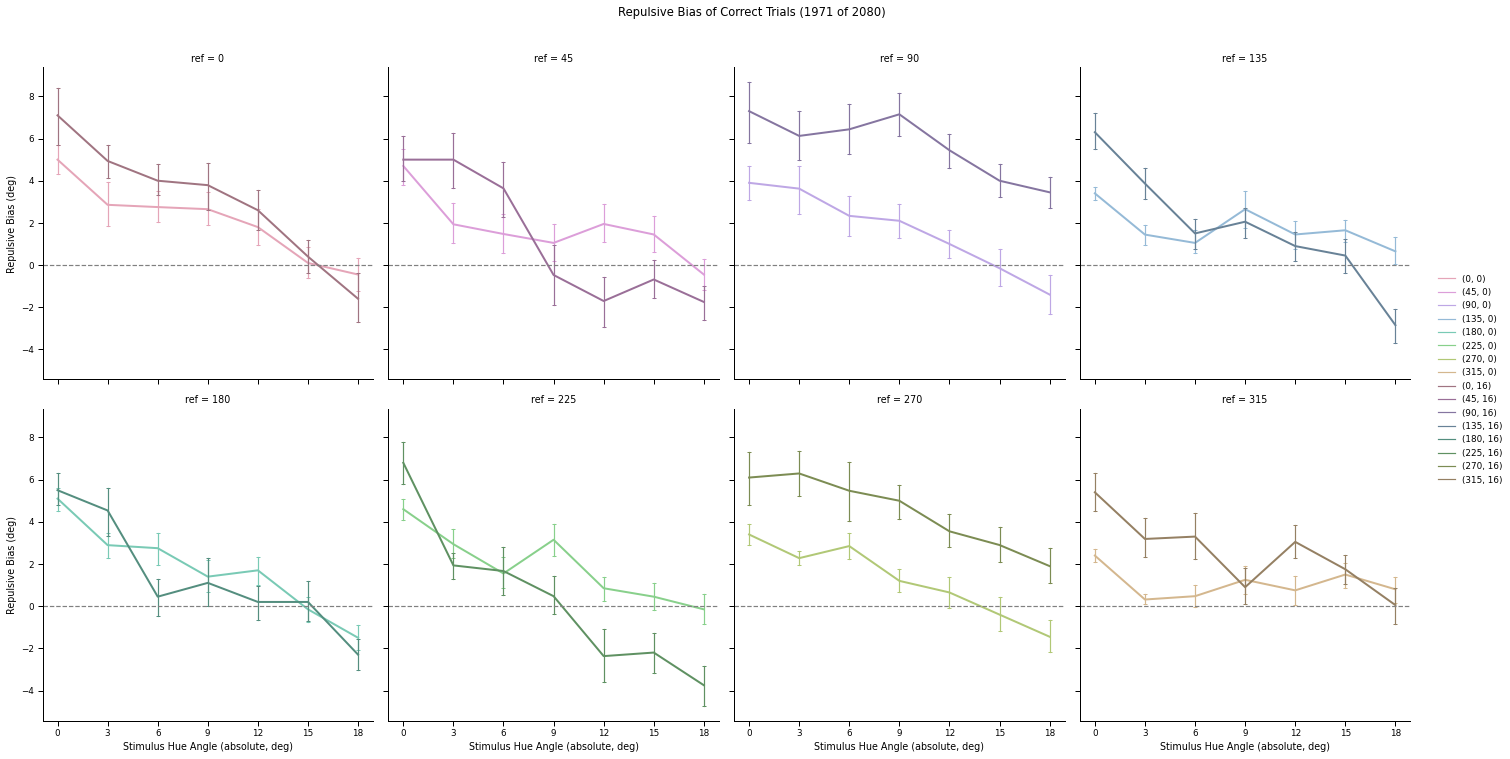

In [195]:
# plot repulsive bias for each refrence hue (cannot separate subjects in this plot)

refs = dat_correct['ref'].sort_values().unique()
noises = dat_correct['noise'].sort_values().unique().astype(float)

palette_combined = {(k, noises[0]):v for k, v in zip(palette.keys(), palette.values())}
palette_combined_darker = {(k, noises[1]):v for k, v in zip(palette_darker.keys(), palette_darker.values())}
palette_combined.update(palette_combined_darker)


g = sns.relplot(data=dat_correct, x='abs_relative_stimulus', y='repulsive_bias', hue=dat_correct[['ref','noise']].apply(tuple, axis=1), col='ref', col_wrap=4,
                facet_kws={'sharey': True, 'sharex': True},
                kind='line', linewidth=2, ci=68, err_style="bars", err_kws={'capsize': 2.}, palette=palette_combined)

g.map(plt.axhline, y=0, color='gray', linestyle='dashed')
g.set(xlabel='Stimulus Hue Angle (absolute, deg)', ylabel='Repulsive Bias (deg)')
g.set(xticks=dat.abs_relative_stimulus.unique().astype(float))

plt.suptitle(f"Repulsive Bias of Correct Trials ({len(dat_correct)} of {len(dat)})", x=0.5, y=1.05)

# plt.savefig(f'data_analysis/{sub}/{sub}_repulsive_bias_by_ref.pdf')

## 4.2 Fitting repulsive bias (linear)

In [178]:
# you need yo install lxml by `pip install lxml` to use statsmodels
! pip install lxml
import statsmodels.api as sm

# Example usage of statsmodel OLS:
# x = dat_correct.abs_relative_stimulus.astype(float)
# y = dat_correct.repulsive_bias.values.astype(float)
# x = sm.add_constant(x)
# model = sm.OLS(y, x)
# results = model.fit()
# results_summary = results.summary()
# results.params

In [179]:
def fit_linear(x, y):
    """
    OLS linear regression on x-y pairs.
    """

    x = sm.add_constant(x.astype(float))
    y = y.astype(float)
    model = sm.OLS(y, x)
    results = model.fit()
    results_summary = results.summary()

    # Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
    results_as_html = results_summary.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    res_df['nobs'] = results.nobs
    res_df['rsquared'] = results.rsquared
    res_df['rsquared_adj'] = results.rsquared_adj

    return res_df

In [180]:
rb_fit = dat_correct.groupby(['sub', 'noise']).\
    apply(lambda x: fit_linear(x['abs_relative_stimulus'], x['repulsive_bias'])).reset_index()


rb_fit = rb_fit.rename({'level_2': 'ivar'}, axis='columns')

# rb_fit.to_csv(f'data_analysis/{sub}/rb_fit.csv', index=False)
rb_fit.head()

/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


sub  noise                   ivar    coef  std err       t  P>|t|  [0.025  \
0  s1      0                  const  3.4169    0.207  16.527    0.0   3.011   
1  s1      0  abs_relative_stimulus -0.2011    0.018 -11.054    0.0  -0.237   
2  s1     16                  const  5.7290    0.296  19.352    0.0   5.148   
3  s1     16  abs_relative_stimulus -0.3527    0.026 -13.766    0.0  -0.403   

   0.975]    nobs  rsquared  rsquared_adj  
0   3.823  1012.0  0.107925      0.107042  
1  -0.165  1012.0  0.107925      0.107042  
2   6.310   959.0  0.165283      0.164411  
3  -0.302   959.0  0.165283      0.164411

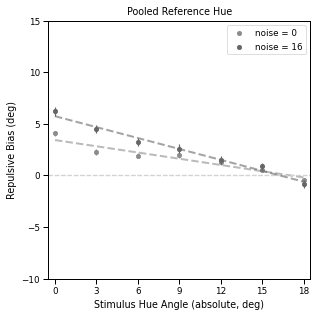

In [181]:
mdat_correct = dat_correct.groupby(['sub', 'noise', 'abs_relative_stimulus'])['repulsive_bias'].\
                agg(['mean', 'std', 'sem']).reset_index()

fig, ax = plt.subplots(figsize=(9/2., 18/4.), nrows=1, ncols=1)
refs = dat_correct.ref.unique()
noises = dat_correct.noise.unique()

color_intens = np.linspace(1.1, 0.8, num=len(noises), endpoint=True)
xx = np.linspace(0, 18, 100, endpoint=True)


for n, c in zip(noises, color_intens):
    ax.axhline(y=0, linestyle='--', color='lightgray')
    color = np.array([.5, .5, .5]) * c
    this_dat = mdat_correct.loc[(mdat_correct.noise==n)]
    ax.scatter(this_dat['abs_relative_stimulus'], this_dat['mean'], marker='o', color=color, label=f"noise = {n}", linestyle='None', s=18)
    ax.errorbar(this_dat['abs_relative_stimulus'], this_dat['mean'], yerr=this_dat['sem'], color=color, linestyle='None')

    this_fit = rb_fit.loc[(rb_fit.noise==n)]
    coef = this_fit[this_fit['ivar'] == 'abs_relative_stimulus']['coef'].to_numpy()
    const = this_fit[this_fit['ivar'] == 'const']['coef'].to_numpy()
    yy = xx * coef + const

    ax.plot(xx, yy, color=color, linestyle='--', linewidth=2., alpha=.6)
ax.set_title(f'Pooled Reference Hue')

ax.set_xticks(dat_correct.abs_relative_stimulus.unique().astype(float))
ax.set_yticks([-10, -5, 0, 5, 10, 15])
ax.set_xlim([-0.5, 18.5])
ax.set_ylim([-10, 15])

ax.set_xlabel('Stimulus Hue Angle (absolute, deg)')
ax.set_ylabel('Repulsive Bias (deg)')

plt.tight_layout()
plt.legend()
# plt.savefig(f'data_analysis/{sub}/{sub}_rb_fit.pdf')

In [184]:
rb_fit_by_ref = dat_correct.groupby(['sub', 'noise', 'ref']).\
        apply(lambda x: fit_linear(x['abs_relative_stimulus'], x['repulsive_bias'])).reset_index()

rb_fit_by_ref = rb_fit_by_ref.rename({'level_3': 'ivar'}, axis='columns')

# rb_fit_by_ref.to_csv(f'data_analysis/{sub}/rb_fit_by_ref.csv', index=False)
rb_fit_by_ref.head()

/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/home/yannan/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order],

sub  noise  ref                   ivar    coef  std err      t  P>|t|  \
0  s1      0    0                  const  4.5284    0.637  7.113  0.000   
1  s1      0    0  abs_relative_stimulus -0.2693    0.055 -4.854  0.000   
2  s1      0   45                  const  3.1501    0.707  4.458  0.000   
3  s1      0   45  abs_relative_stimulus -0.1668    0.062 -2.706  0.008   
4  s1      0   90                  const  4.3965    0.693  6.343  0.000   

   [0.025  0.975]   nobs  rsquared  rsquared_adj  
0   3.268   5.789  124.0  0.161884      0.155014  
1  -0.379  -0.160  124.0  0.161884      0.155014  
2   1.751   4.549  124.0  0.056613      0.048880  
3  -0.289  -0.045  124.0  0.056613      0.048880  
4   3.024   5.769  124.0  0.171020      0.164225

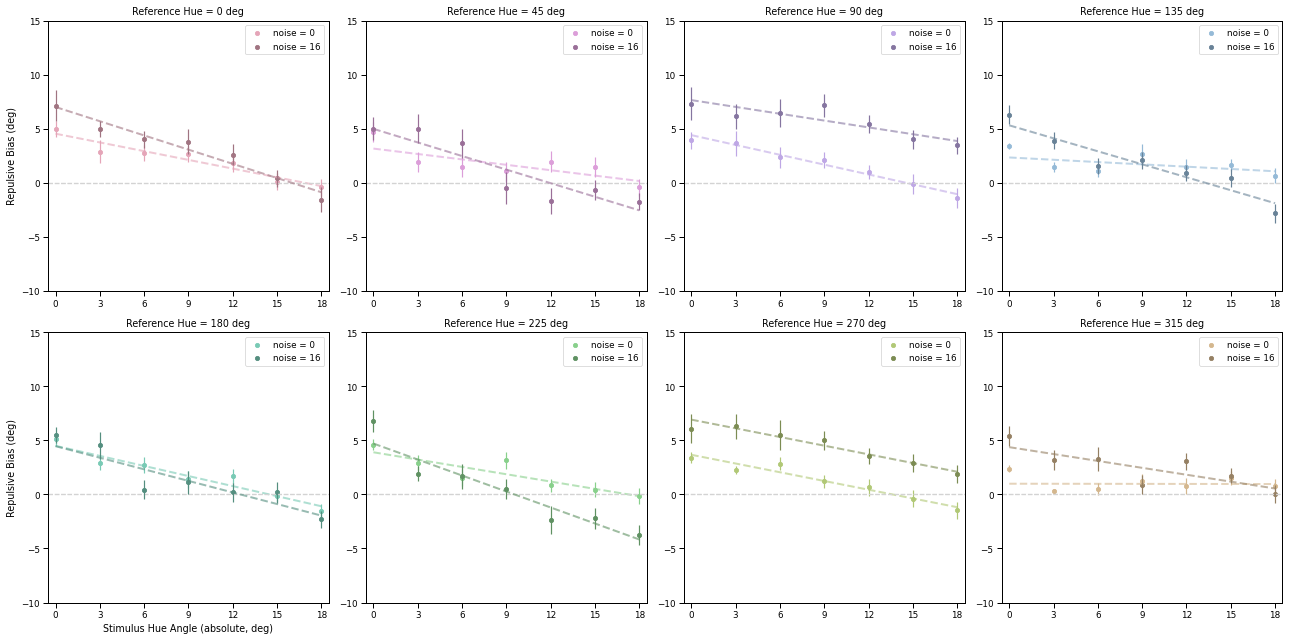

In [185]:
mdat_correct = dat_correct.groupby(['sub', 'noise', 'ref', 'abs_relative_stimulus'])['repulsive_bias'].\
                agg(['mean', 'std', 'sem']).reset_index()


fig, axes = plt.subplots(figsize=(18, 9), nrows=2, ncols=4)
refs = dat_correct.ref.unique()
noises = dat_correct.noise.unique()

color_intens = np.linspace(1.1, 0.8, num=len(noises), endpoint=True)
xx = np.linspace(0, 18, 100, endpoint=True)

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    ref = refs[idx]
    for n, c in zip(noises, color_intens):
        ax.axhline(y=0, linestyle='--', color='lightgray')

        # color = np.array(colorcode[ref]) * c
        color = palette_combined[(ref, n)]
        this_dat = mdat_correct.loc[(mdat_correct.ref == ref) & (mdat_correct.noise==n)]
        ax.scatter(this_dat['abs_relative_stimulus'], this_dat['mean'], marker='o', color=color, label=f"noise = {n}", linestyle='None', s=18)
        ax.errorbar(this_dat['abs_relative_stimulus'], this_dat['mean'], yerr=this_dat['sem'], color=color, linestyle='None')

        this_fit = rb_fit_by_ref.loc[(rb_fit_by_ref.ref == ref) & (rb_fit_by_ref.noise==n)]
        coef = this_fit[this_fit['ivar'] == 'abs_relative_stimulus']['coef'].to_numpy()
        const = this_fit[this_fit['ivar'] == 'const']['coef'].to_numpy()
        yy = xx * coef + const

        ax.set_title(f'Reference Hue = {ref} deg')
        ax.plot(xx, yy, color=color, linestyle='--', linewidth=2., alpha=.6)

        ax.set_xticks(dat_correct.abs_relative_stimulus.unique().astype(float))
        ax.set_yticks([-10, -5, 0, 5, 10, 15])
        ax.set_xlim([-0.5, 18.5])
        ax.set_ylim([-10, 15])
        ax.legend()


axes[1, 0].set_xlabel('Stimulus Hue Angle (absolute, deg)')

axes[0, 0].set_ylabel('Repulsive Bias (deg)')
axes[1, 0].set_ylabel('Repulsive Bias (deg)')

plt.tight_layout()
# plt.savefig(f'data_analysis/{sub}/{sub}_rb_fit_by_ref.pdf')
    

## 4.3 Fitting parameters vs. reference hues

/tmp/ipykernel_4374/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_4374/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


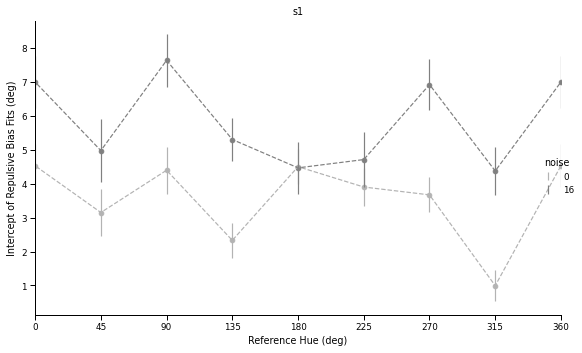

In [187]:
intercepts = rb_fit_by_ref[rb_fit_by_ref.ivar=='const']

g = sns.FacetGrid(fill_gap(intercepts), hue="noise", palette=sns.color_palette(noise_palette[0:2]), height=5, aspect=1.5)
g.map(plt.scatter, 'ref', 'coef')
g.map(plt.plot, 'ref', 'coef', linestyle='--')
g.map(plt.errorbar, 'ref', 'coef', 'std err', linestyle='None')

g.set(title=f'{sub}')
g.set(xlabel='Reference Hue (deg)', xlim=[0, 360], xticks=np.arange(0, 360+45, 45))
g.set(ylabel='Intercept of Repulsive Bias Fits (deg)')
g.add_legend()

plt.tight_layout()
# plt.savefig(f'data_analysis/{sub}/{sub}_rb_fit_intercept.pdf')


/tmp/ipykernel_4374/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_4374/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


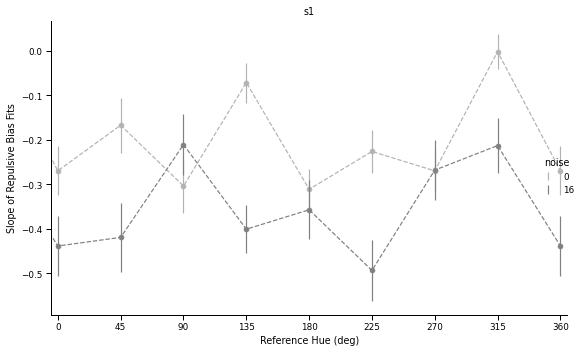

In [196]:
slopes = rb_fit_by_ref[rb_fit_by_ref.ivar=='abs_relative_stimulus']

g = sns.FacetGrid(fill_gap(slopes), hue="noise", palette=sns.color_palette(noise_palette[0:2]), height=5, aspect=1.5)
g.map(plt.scatter, 'ref', 'coef')
g.map(plt.plot, 'ref', 'coef', linestyle='--')
g.map(plt.errorbar, 'ref', 'coef', 'std err', linestyle='None')

g.set(title=f'{sub}')
g.set(xlabel='Reference Hue (deg)', xlim=[-5, 360+5], xticks=np.arange(0, 360+45, 45))
g.set(ylabel='Slope of Repulsive Bias Fits')
g.add_legend()

plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_rb_fit_slope.pdf')


/tmp/ipykernel_4374/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_4374/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


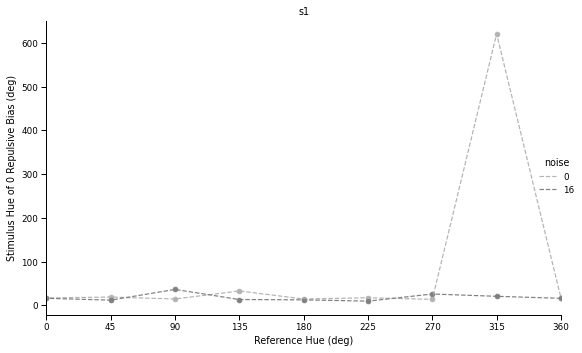

In [197]:
x_intercepts = rb_fit_by_ref.groupby(['sub', 'noise', 'ref']).apply(lambda x: -x[x.ivar=='const']['coef'].to_numpy()/ x[x.ivar=='abs_relative_stimulus']['coef'].to_numpy()).reset_index(name='x_intercept')

g = sns.FacetGrid(fill_gap(x_intercepts), hue="noise", palette=sns.color_palette(noise_palette[0:2]), height=5, aspect=1.5)
g.map(plt.scatter, 'ref', 'x_intercept')
g.map(plt.plot, 'ref', 'x_intercept', linestyle='--')

g.set(title=f'{sub}')
g.set(xlabel='Reference Hue (deg)', xlim=[0, 360], xticks=np.arange(0, 360+45, 45))
g.set(ylabel='Stimulus Hue of 0 Repulsive Bias (deg)')
g.add_legend()

plt.tight_layout()
plt.savefig(f'data_analysis/{sub}/{sub}_rb_intercept_x.pdf')


## 4.4 Repulsive Bias right at the reference

/tmp/ipykernel_12999/3462225913.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_12999/3462225913.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


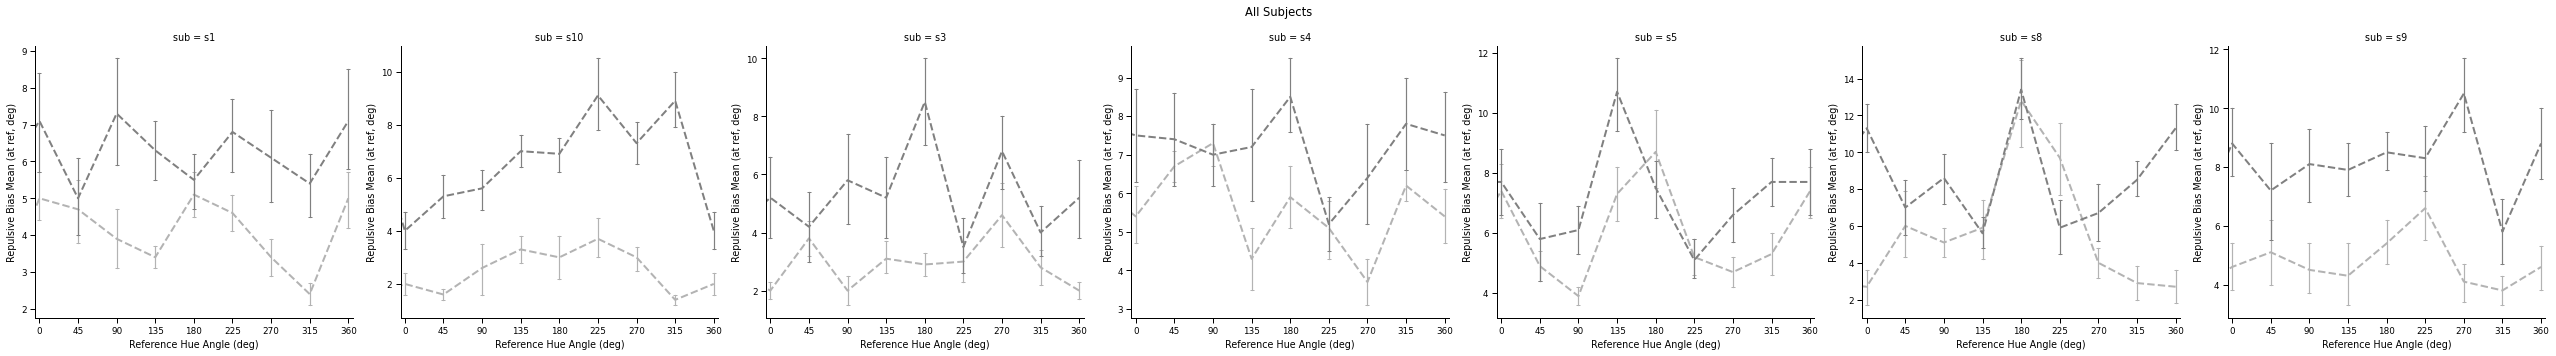

In [24]:
sel_dat_correct = dat_correct[dat_correct.relative_stimulus==0]

# Column by subject
g = sns.relplot(data=fill_gap(sel_dat_correct).sort_values(by='sub').reset_index(), x='ref', y='repulsive_bias', hue='noise', ci=68, col='sub',
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': False})

# Pooled data
# g = sns.relplot(data=fill_gap(sel_dat_correct).sort_values(by='sub').reset_index(), x='ref', y='repulsive_bias', hue='noise', ci=68, 
#             kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': True})

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Mean (at ref, deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[0, 10.5])

plt.suptitle(f'All Subjects')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()

# 5.0 Bias Plots

The plots can be used to compare with Klauke's paper.

Only use trials with correct judgment to plot.

## 5.1 Simply plot the bias

We can also plot for all trials. Have tried with pooled data and found not much difference from selecting correctly judged trials (~90%) only.

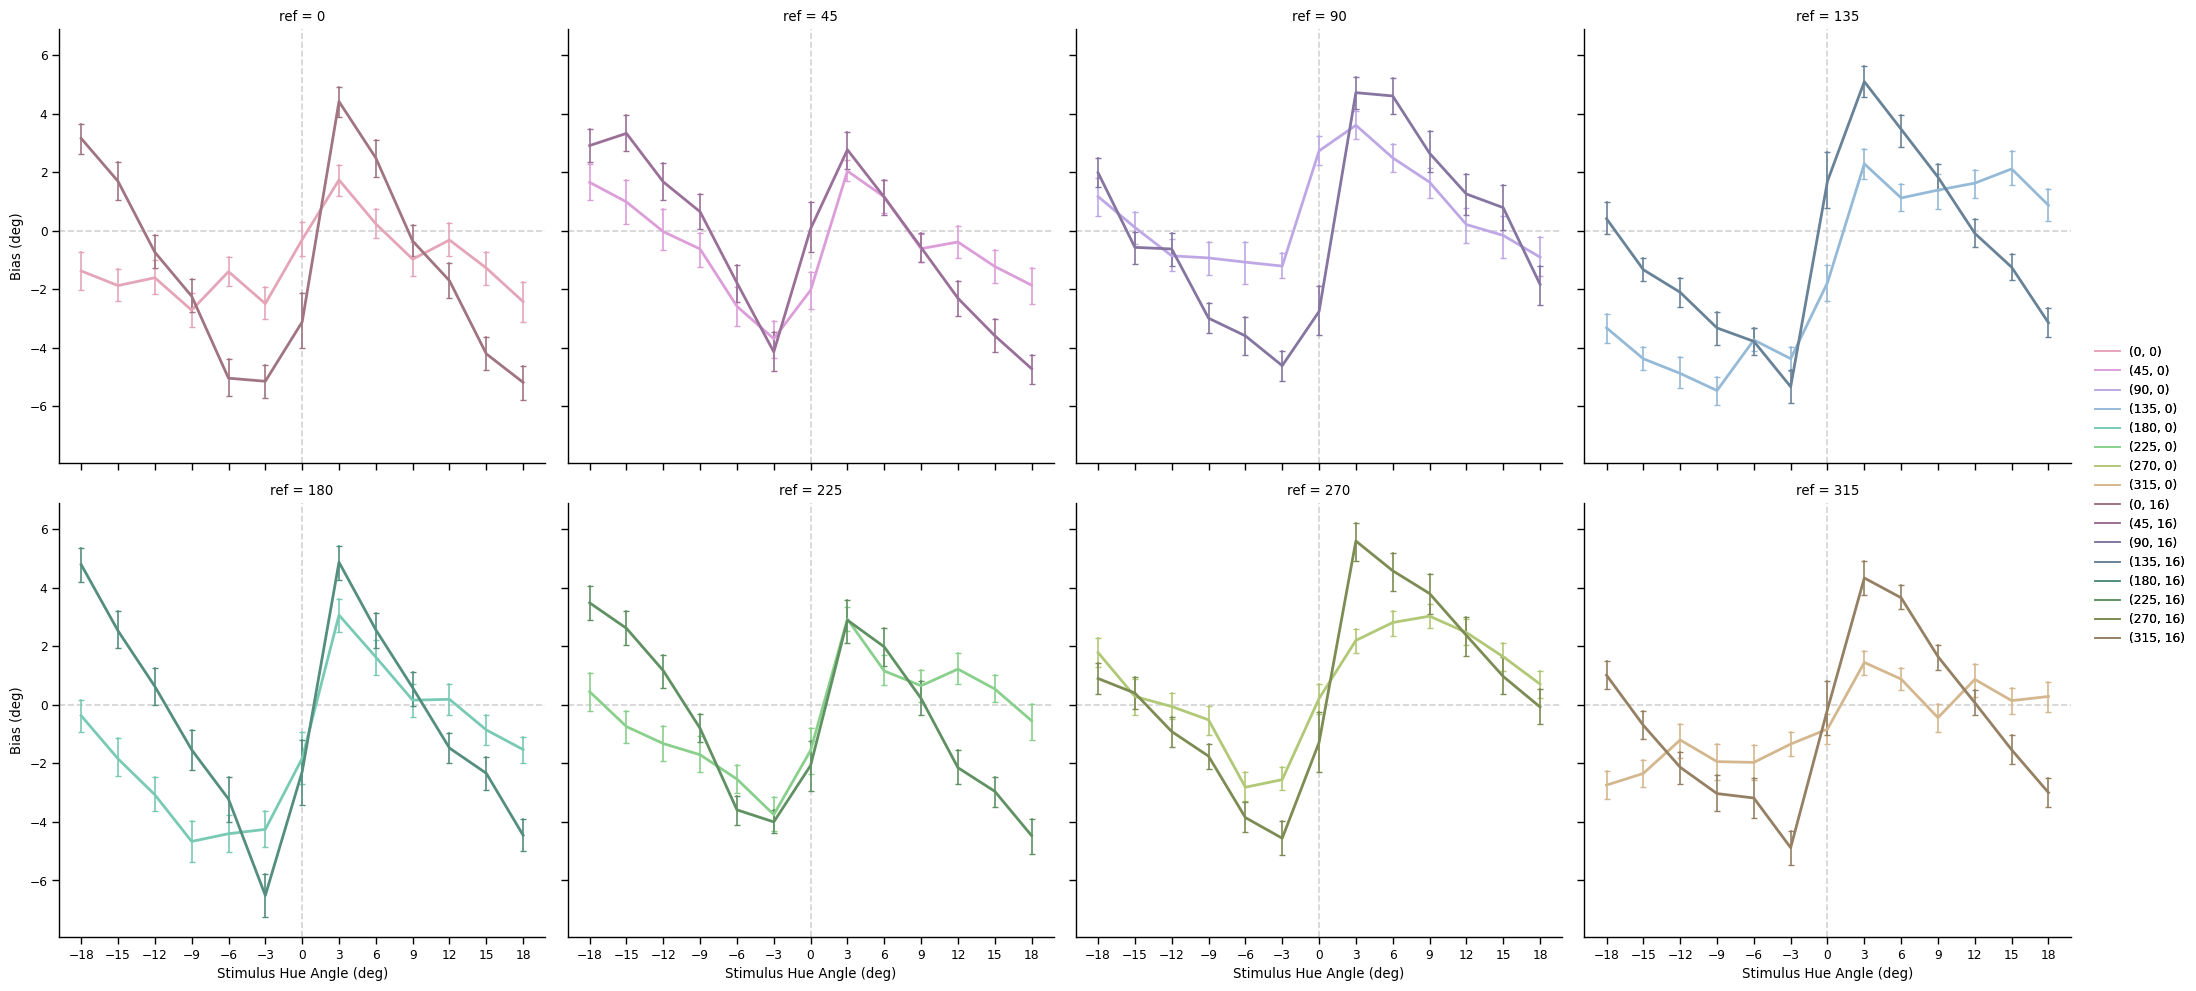

In [73]:
dat_correct = dat[dat.ref_judge_correct == 1].sort_values(by=['sub', 'noise', 'ref'])

refs = dat_correct['ref'].sort_values().unique()
noises = dat_correct['noise'].sort_values().unique().astype(float)

palette_combined = {(k, noises[0]):v for k, v in zip(palette.keys(), palette.values())}
palette_combined_darker = {(k, noises[1]):v for k, v in zip(palette_darker.keys(), palette_darker.values())}
palette_combined.update(palette_combined_darker)

g = sns.relplot(data=dat_correct, x='relative_stimulus', y='bias', hue=dat_correct[['ref','noise']].apply(tuple, axis=1), col='ref', col_wrap=4,
                facet_kws={'sharey': True, 'sharex': True}, ci=68, 
                kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=palette_combined, zorder=3)

g.map(plt.axhline, y=0, color='lightgray', linestyle='dashed', zorder=0)
g.map(plt.axvline, x=0, color='lightgray', linestyle='dashed', zorder=0)

g.set(xlabel='Stimulus Hue Angle (deg)', ylabel='Bias (deg)')
g.set(xticks=dat_correct.relative_stimulus.unique().astype(float))
g.add_legend()

# plt.tight_layout()
#plt.savefig(f'data_analysis/{sub}/{sub}_bias.pdf')


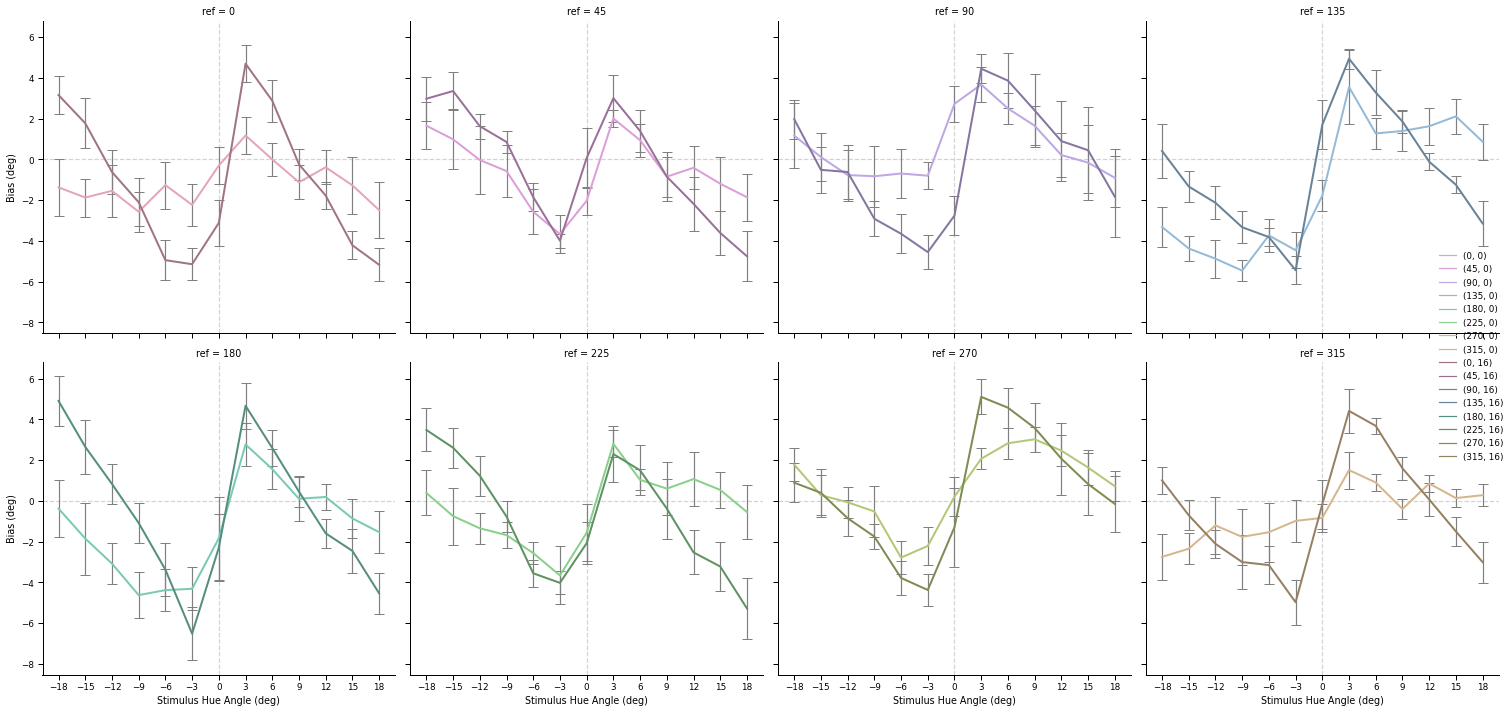

In [12]:
# plot errorbar (SEM) across subjects

dat_correct = dat[dat.ref_judge_correct == 1].sort_values(by=['sub', 'noise', 'ref'])

refs = dat_correct['ref'].sort_values().unique()
noises = dat_correct['noise'].sort_values().unique().astype(float)

palette_combined = {(k, noises[0]):v for k, v in zip(palette.keys(), palette.values())}
palette_combined_darker = {(k, noises[1]):v for k, v in zip(palette_darker.keys(), palette_darker.values())}
palette_combined.update(palette_combined_darker)

# m_bias = dat_correct.groupby(['sub', 'noise', 'ref', 'relative_stimulus'])['bias'].agg(['mean', 'std']).reset_index()
m_bias = dat_correct.groupby(['sub', 'noise', 'ref', 'relative_stimulus'])['bias'].mean().reset_index()\
                    .groupby(['noise', 'ref', 'relative_stimulus'])['bias'].agg(['mean', 'sem']).reset_index()

# g = sns.FacetGrid(data=m_bias, col='ref', col_wrap=4, sharey=True, sharex=True,  palette=palette_combined,)
# g.map(sns.lineplot, 'relative_stimulus', 'mean', hue=m_bias[['ref','noise']].apply(tuple, axis=1), zorder=3)

g = sns.relplot(data=m_bias, x='relative_stimulus', y='mean', hue=m_bias[['ref','noise']].apply(tuple, axis=1), col='ref', col_wrap=4,
                facet_kws={'sharey': True, 'sharex': True}, 
                kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=palette_combined, zorder=3)
g.map(plt.errorbar, 'relative_stimulus', 'mean', 'sem', linestyle='None', capsize=5, color='gray', zorder=2)


g.map(plt.axhline, y=0, color='lightgray', linestyle='dashed', zorder=0)
g.map(plt.axvline, x=0, color='lightgray', linestyle='dashed', zorder=0)

g.set(xlabel='Stimulus Hue Angle (deg)', ylabel='Bias (deg)')
g.set(xticks=m_bias.relative_stimulus.unique().astype(float))

# plt.tight_layout()

In [46]:
# max bias magnitude, average across subjects

m_bias[m_bias['mean'] == m_bias.groupby(['ref', 'noise'])['mean'].transform(max)].rename({'mean': 'max_abs_bias'}, axis='columns')


noise  ref  relative_stimulus  max_abs_bias       sem
7        0    0                  3      1.176190  0.926119
20       0   45                  3      2.009410  0.407073
33       0   90                  3      3.675283  0.855210
46       0  135                  3      3.552721  1.813399
59       0  180                  3      2.776190  1.058338
72       0  225                  3      2.806803  0.664022
87       0  270                  9      3.028571  0.611678
98       0  315                  3      1.516667  0.906685
111     16    0                  3      4.698299  0.897485
118     16   45                -15      3.357143  0.914744
137     16   90                  3      4.451247  0.709415
150     16  135                  3      4.941950  0.485139
156     16  180                -18      4.911111  1.207996
169     16  225                -18      3.485714  1.053888
189     16  270                  3      5.109240  0.859752
202     16  315                  3      4.420295  1.099284

## 5.2 Mean magnitude of absoulute bias (near ref)

(might be better to use the term "magnitude"? since it is always absolute values)

/tmp/ipykernel_3330/710381019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_dat_correct['abs_bias'] = sel_dat_correct['bias'].abs()
/tmp/ipykernel_3330/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_3330/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

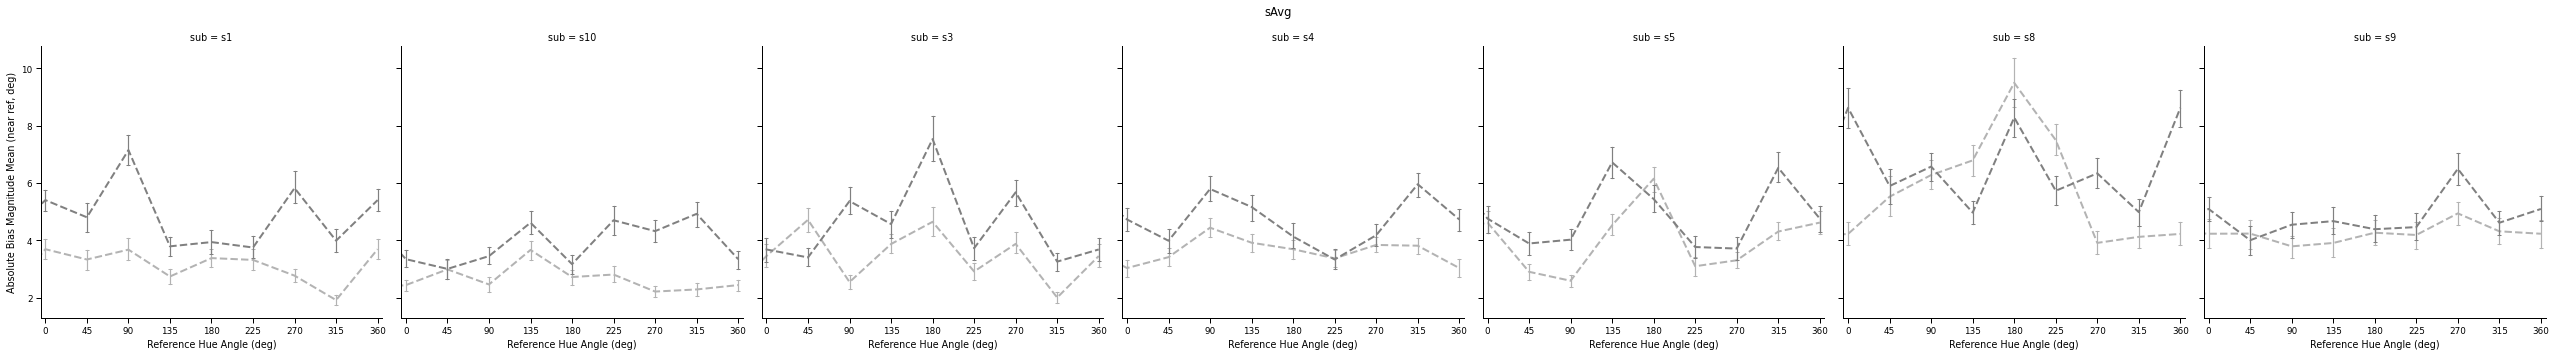

In [151]:
# define the range to average, for exmaple in [-9, 9], so the absolute stimulus value should be smaller than 9
sel_dat_correct = dat_correct[dat_correct.abs_relative_stimulus <= 9]

# convert bias to non-negative magnitudes
sel_dat_correct['abs_bias'] = sel_dat_correct['bias'].abs()

# plot mean magnitudes with error bars

# Column by subject
g = sns.relplot(data=fill_gap(sel_dat_correct).sort_values(by='sub').reset_index(), x='ref', y='abs_bias', hue='noise', ci=68, col='sub',
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': True})

# Pooled data
# g = sns.relplot(data=fill_gap(sel_dat_correct).sort_values(by='sub').reset_index(), x='ref', y='abs_bias', hue='noise', ci=68, 
#             kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': True})

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Absolute Bias Magnitude Mean (near ref, deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[0, 10.5])

plt.suptitle(f'{sub}')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()
# plt.savefig(f'data_analysis/{sub}/{sub}_bias_amp_mean_npolar.pdf')


## 5.3 Mean magnitude of repulsive bias (near ref)

/tmp/ipykernel_3330/2407424548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))
/tmp/ipykernel_3330/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_3330/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



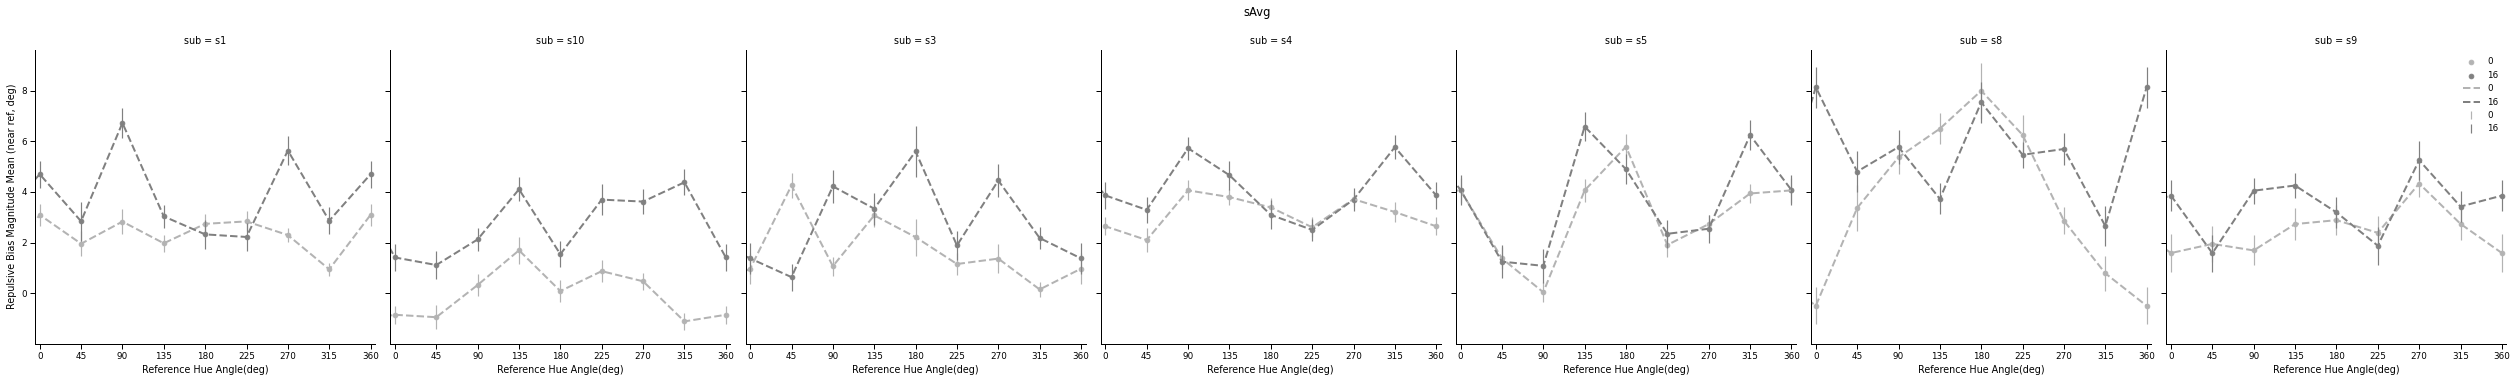

In [196]:
dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))

sel_dat_correct = dat_correct[dat_correct.abs_relative_stimulus <= 9]

# Column by subject
msel_rb = sel_dat_correct.groupby(['sub', 'noise', 'ref'])['repulsive_bias'].agg(['mean','sem']).reset_index()
g = sns.FacetGrid(fill_gap(msel_rb).sort_values(by=['sub', 'ref']), hue="noise", col='sub', height=5, aspect=1,  palette=sns.color_palette(noise_palette[0:2]))

# Pooled data
# msel_rb = sel_dat_correct.groupby(['noise', 'ref'])['repulsive_bias'].agg(['mean','sem']).reset_index()
# g = sns.FacetGrid(fill_gap(msel_rb).sort_values(by=['ref']), hue="noise",  height=5, aspect=1,  palette=sns.color_palette(noise_palette[0:2]))

g.map(plt.scatter, 'ref', 'mean')
g.map(plt.plot, 'ref', 'mean', linestyle='dashed', linewidth=2, )
g.map(plt.errorbar, 'ref', 'mean', 'sem', linestyle='None')

g.set(xlabel='Reference Hue Angle(deg)', xlim=[0, 360], xticks=np.arange(0, 360+45, 45))
g.set(ylabel='Repulsive Bias Magnitude Mean (near ref, deg)')

g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[0, 10.5])

plt.suptitle(f'{sub}', y=1.05)
plt.legend(loc='upper right', frameon=False)

# plt.tight_layout()
# plt.savefig(f'data_analysis/{sub}/{sub}_rb_range_0_6.pdf')


## 5.4 Maximum magnitude of bias (near ref)

This plot simply takes the peak magnitude corresponding to each ref with error bars, and plot them verus the ref.

/tmp/ipykernel_46462/3462225913.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_46462/3462225913.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


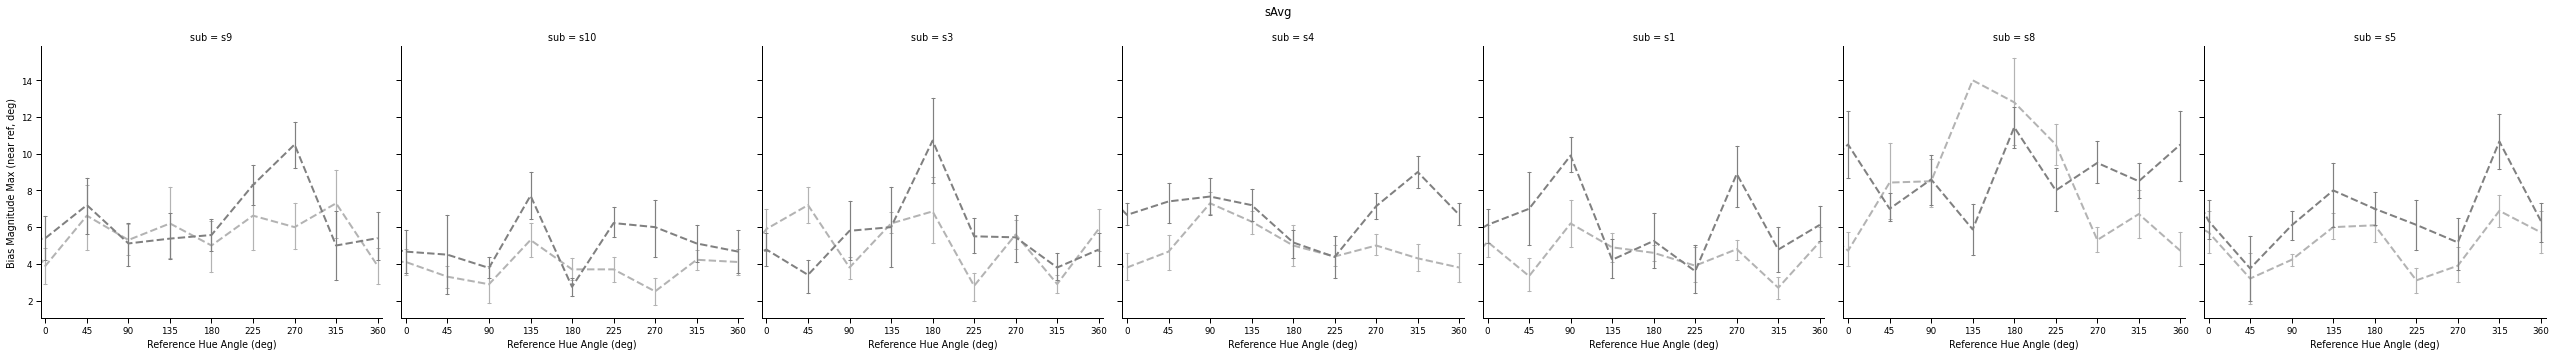

In [34]:
# define the range to find the maximum peak, for exmaple in [-9, 9], so the absolute stimulus value should be smaller than 9
sel_dat_correct = dat_correct[dat_correct.abs_relative_stimulus <= 9]

# mamp = sel_dat_correct.groupby(['sub', 'ref', 'noise'])['bias'].apply(lambda x: np.max(np.abs(np.mean(x)))).reset_index()

# g = sns.FacetGrid(data=mamp, col='noise', row='sub', hue='ref', subplot_kws=dict(projection='polar'), height=6, despine=False, palette=palette)
# g.map(sns.scatterplot, 'ref_rad', 'bias', s=80.)

# g = sns.FacetGrid(data=mamp, col='noise', row='sub', hue='ref', height=6, despine=False, palette=palette)
# g.map(sns.scatterplot, 'ref', 'bias',)
# g.set(ylim=[5, 20], yticks=[5, 10, 15, 20])

# calculate the absolute value of mean bias for each stimulus (essentially are the mean data points in 5.1 bias plots)
amp = sel_dat_correct.groupby(['sub', 'ref', 'noise', 'relative_stimulus'])['bias'].apply(lambda x: np.abs(np.mean(x))).reset_index()

# find the magnitude peak
mamp = amp[amp['bias'] == amp.groupby(['sub', 'ref', 'noise'])['bias'].transform(max)].rename({'bias': 'max_abs_bias'}, axis='columns')

# match the data with magnitude peak; purpose: have a group of data rather than only the mean, so we can plot error bars later
bias_merged = sel_dat_correct.merge(mamp, how='left', indicator=True).query("max_abs_bias.notna()")
bias_merged['abs_bias'] = bias_merged['bias'].abs()

# bias_merged['ref_rad'] = bias_merged['ref'].apply(np.deg2rad)

# Column by subject
g = sns.relplot(data=fill_gap(bias_merged).reset_index(), x='ref', y='abs_bias', hue='noise', ci=68,  col='sub',
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': True})

# Pooled data
# g = sns.relplot(data=fill_gap(bias_merged).reset_index(), x='ref', y='abs_bias', hue='noise', ci=68,  
#             kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), linestyle='dashed', facet_kws={'sharey': True})


g.set(xlabel='Reference Hue Angle (deg)', ylabel='Bias Magnitude Max (near ref, deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[0, 9])

plt.suptitle(f'{sub}')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()
# plt.savefig(f'data_analysis/{sub}/{sub}_bias_amp_max_npolar.pdf')


## 5.5 Present individual's data together in one plot

/tmp/ipykernel_3330/1835557575.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_dat_correct['abs_bias'] = sel_dat_correct['bias'].abs()
/tmp/ipykernel_3330/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_3330/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Text(0.5, 0.98, 'sAvg')

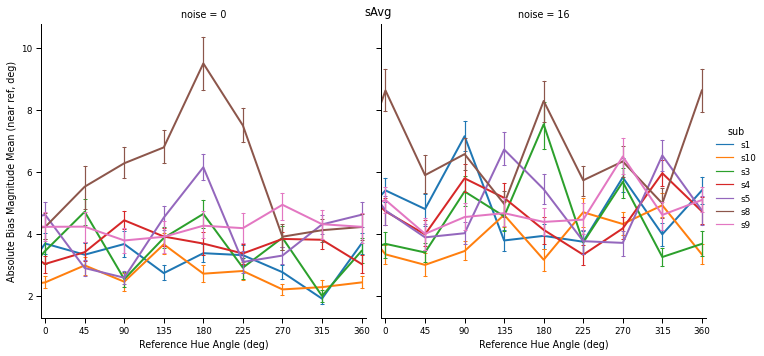

In [146]:
# All individual's data for plot 5.2

# define the range to average, for exmaple in [-9, 9], so the absolute stimulus value should be smaller than 9
sel_dat_correct = dat_correct[dat_correct.abs_relative_stimulus <= 9]

# convert bias to non-negative magnitudes
sel_dat_correct['abs_bias'] = sel_dat_correct['bias'].abs()

# plot mean magnitudes with error bars
g = sns.relplot(data=fill_gap(sel_dat_correct).reset_index().sort_values(by='sub'), x='ref', y='abs_bias', hue='sub', ci=68, col='noise',
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, facet_kws={'sharey': True, 'sharex': True, 'legend_out':True})

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Absolute Bias Magnitude Mean (near ref, deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[1.5, 5])

plt.suptitle(f'{sub}')
# plt.tight_layout()

# Note this should not overwrite sAVG plots
# plt.savefig(f'data_analysis/sAll/all_sub_bias_amp_mean_npolar.pdf')


/tmp/ipykernel_3330/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_3330/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


Text(0.5, 0.98, 'sAvg')

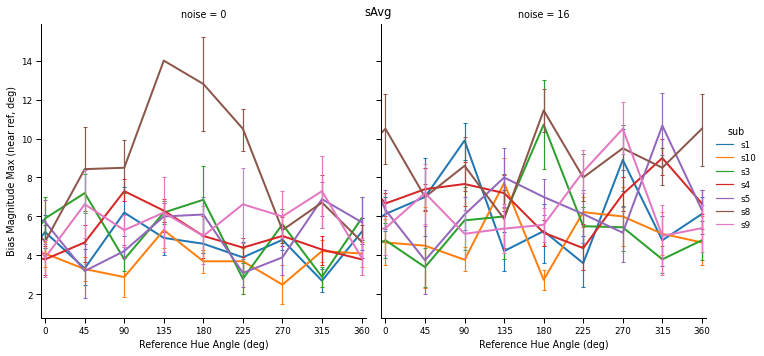

In [147]:
# All individual's data for plot 5.4

# define the range to find the maximum peak, for exmaple in [-9, 9], so the absolute stimulus value should be smaller than 9
sel_dat_correct = dat_correct[dat_correct.abs_relative_stimulus <= 9]

# mamp = sel_dat_correct.groupby(['sub', 'ref', 'noise'])['bias'].apply(lambda x: np.max(np.abs(np.mean(x)))).reset_index()

# g = sns.FacetGrid(data=mamp, col='noise', row='sub', hue='ref', subplot_kws=dict(projection='polar'), height=6, despine=False, palette=palette)
# g.map(sns.scatterplot, 'ref_rad', 'bias', s=80.)

# g = sns.FacetGrid(data=mamp, col='noise', row='sub', hue='ref', height=6, despine=False, palette=palette)
# g.map(sns.scatterplot, 'ref', 'bias',)
# g.set(ylim=[5, 20], yticks=[5, 10, 15, 20])

# calculate the absolute value of mean bias for each stimulus (essentially are the mean data points in 5.1 bias plots)
amp = sel_dat_correct.groupby(['sub', 'ref', 'noise', 'relative_stimulus'])['bias'].apply(lambda x: np.abs(np.mean(x))).reset_index()

# find the magnitude peak
mamp = amp[amp['bias'] == amp.groupby(['sub', 'ref', 'noise'])['bias'].transform(max)].rename({'bias': 'max_abs_bias'}, axis='columns')

# match the data with magnitude peak; purpose: have a group of data rather than only the mean, so we can plot error bars later
bias_merged = sel_dat_correct.merge(mamp, how='left', indicator=True).query("max_abs_bias.notna()")
bias_merged['abs_bias'] = bias_merged['bias'].abs()

# bias_merged['ref_rad'] = bias_merged['ref'].apply(np.deg2rad)


g = sns.relplot(data=fill_gap(bias_merged).reset_index().sort_values(by='sub'), x='ref', y='abs_bias', hue='sub', ci=68, col='noise', 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.})

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Bias Magnitude Max (near ref, deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(ylim=[0, 9])

plt.suptitle(f'{sub}')
# g.legend.remove()
# plt.legend(loc='upper right', frameon=False)

# plt.tight_layout()

# Note this should not overwrite sAVG plots
# plt.savefig(f'data_analysis/sAll/all_sub_bias_amp_max_npolar.pdf')


## 5.6 Summary of Bias (repulsive only)

This part can be also moved to 4.0 Repulsive Bias, but better to be here, perhaps..

In [86]:
# similar to the below/old plot, but sum the mean bias of each stimulus values, and add errorbars for each subject

# compute repulsive bias
dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))

# select correct ones
dat_correct = dat[dat.ref_judge_correct == 1].sort_values(by=['noise', 'ref'])

sel_dat_correct = dat_correct[dat_correct.repulsive_bias >= 0]

rb_by_ref = sel_dat_correct.groupby(['sub', 'noise', 'ref', 'relative_stimulus']).repulsive_bias.agg(['count', 'mean', 'std']).reset_index()
rb_by_ref['variance'] = rb_by_ref['std']**2

rb_summary_err = rb_by_ref.groupby(['sub', 'noise', 'ref'])[['mean', 'variance']].agg(['count', 'sum']).droplevel(0, axis=1).reset_index()
rb_summary_err.columns = ['sub', 'noise', 'ref', 'sum_count', 'sum_mean', 'var_count', 'sum_var']
rb_summary_err['n_rb'] = sel_dat_correct.groupby(['sub', 'noise', 'ref']).repulsive_bias.count().reset_index()['repulsive_bias']
rb_summary_err['sum_std'] = np.sqrt(rb_summary_err['sum_var'])
# rb_summary_err['sum_sem'] = rb_summary_err['sum_std']/np.sqrt(rb_summary_err['sum_count'])
# rb_summary_err['sum_sem'] = rb_summary_err['sum_std']/np.sqrt(rb_summary_err['n_rb'])
rb_summary_err.head()



/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/386763194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))


sub  noise  ref  sum_count   sum_mean  var_count    sum_var  n_rb   sum_std
0  s1      0    0         13  39.431746         13  58.873016    92  7.672875
1  s1      0   45         13  45.026190         13  94.858730    84  9.739545
2  s1      0   90         13  36.102778         11  65.707540    82  8.106019
3  s1      0  135         13  34.069048         13  45.568254   102  6.750426
4  s1      0  180         13  34.698016         12  62.809127    97  7.925221

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


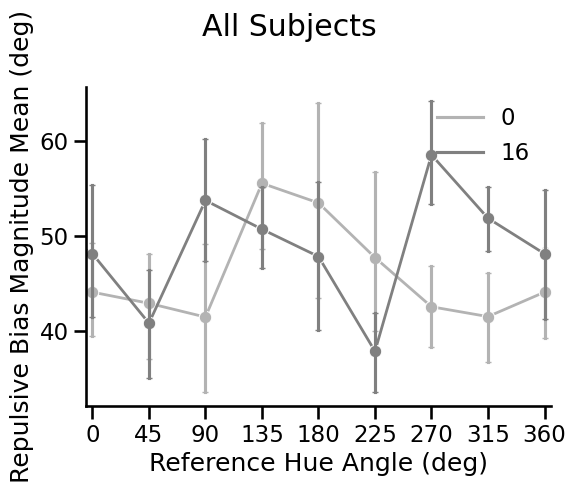

In [87]:
# rb_summary_err = rb_summary_err.query("sub not in ['s3', 's8']")

g = sns.relplot(data=fill_gap(rb_summary_err).reset_index().sort_values(by='sub'), x='ref', y='sum_mean',  ci=68, hue='noise', 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), marker="o")

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Mean (deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])

plt.suptitle('All Subjects')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.savefig(f'main_figures/{sub}/{sub}_talk_repulsive_bias_magnitude_mean.pdf')

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


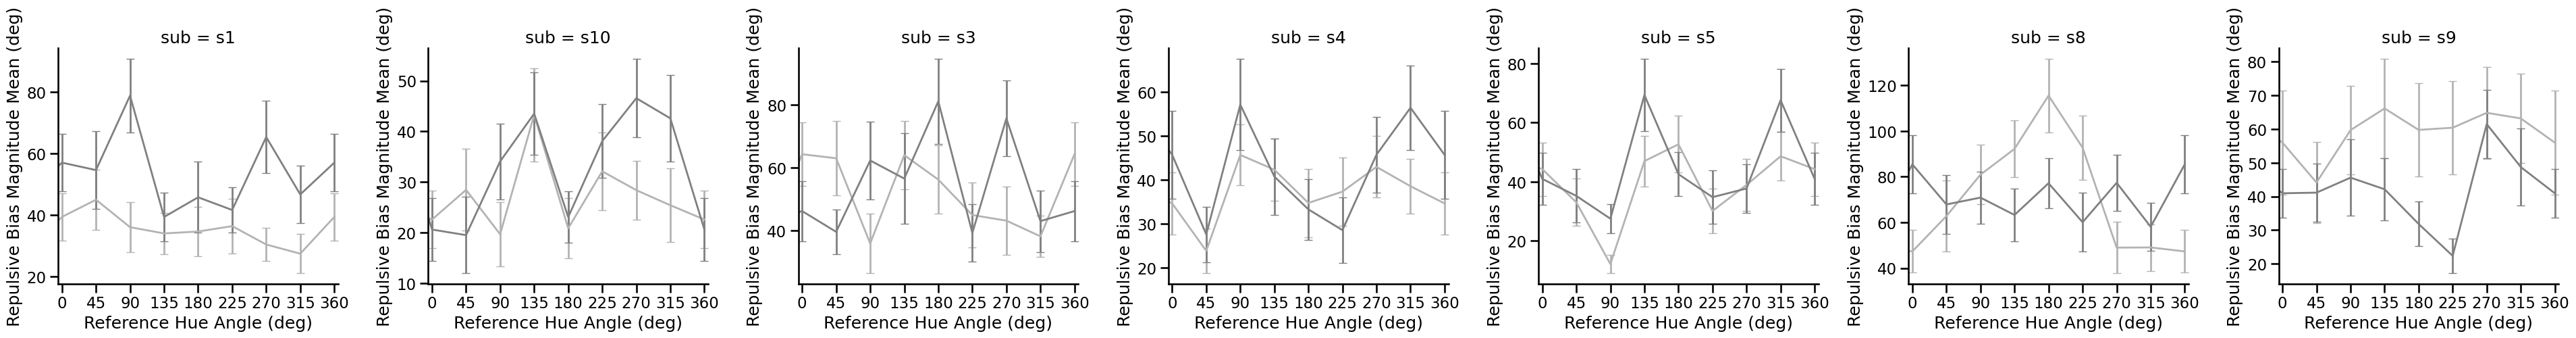

In [90]:
g = sns.FacetGrid(fill_gap(rb_summary_err).sort_values(by=['sub', 'ref', 'noise']), hue="noise", col='sub', sharey=False, palette=sns.color_palette(noise_palette[0:2]), height=5, aspect=1.1)
# g.map(plt.plot, 'ref', 'sum_mean', linestyle='--')
g.map(plt.errorbar, 'ref', 'sum_mean', 'sum_std', linestyle='-', lw=2, capsize=4)

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Mean (deg)')#, yscale="log")
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365], )
#g.add_legend()
plt.tight_layout()
plt.savefig(f'main_figures/{sub}/{sub}_talk_repulsive_bias_magnitude_mean_ref.pdf')

In [80]:
# compute repulsive bias
dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))

# select correct ones
dat_correct = dat[dat.ref_judge_correct == 1].sort_values(by=['noise', 'ref'])

sel_dat_correct = dat_correct[dat_correct.repulsive_bias >= 0]

# For calculating bias area:
# sel_dat_correct['bias_area'] = sel_dat_correct['repulsive_bias'] * abs(sel_dat_correct['relative_stimulus'])

rb_summary = sel_dat_correct.groupby(['sub', 'noise', 'ref']).repulsive_bias.agg(['count', 'sum', 'mean', 'std', 'sem']).reset_index()

# rb_summary['area'] = rb_summary['count'] * rb_summary['sum'] * 3  # maybe approximate areas...
rb_summary.head()

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/902248722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))


sub  noise  ref  count    sum      mean       std       sem
0  s1      0    0     92  324.0  3.521739  2.586857  0.269699
1  s1      0   45     84  293.0  3.488095  2.955469  0.322468
2  s1      0   90     82  295.0  3.597561  3.001480  0.331458
3  s1      0  135    102  276.0  2.705882  2.027476  0.200750
4  s1      0  180     97  285.0  2.938144  2.465658  0.250350

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


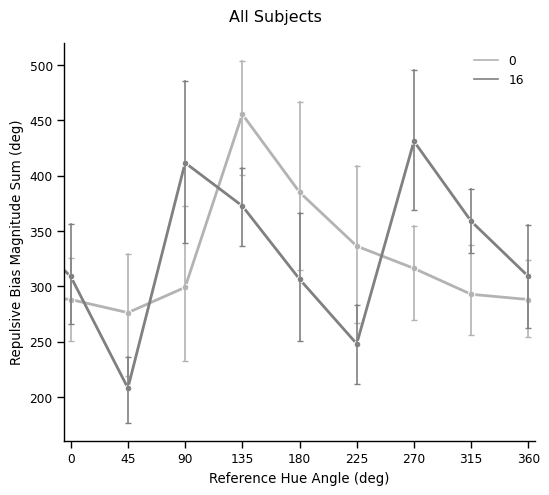

In [81]:
# s3 and s8 have different data for noise 0 ...
# rb_summary = rb_summary.query("sub not in ['s3', 's8']")

g = sns.relplot(data=fill_gap(rb_summary).reset_index(), x='ref', y='sum', hue='noise', ci=68, 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), marker="o")

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Sum (deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])
# g.set(yscale="log")

plt.suptitle('All Subjects')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()

/tmp/ipykernel_3330/359059073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/tmp/ipykernel_3330/359059073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


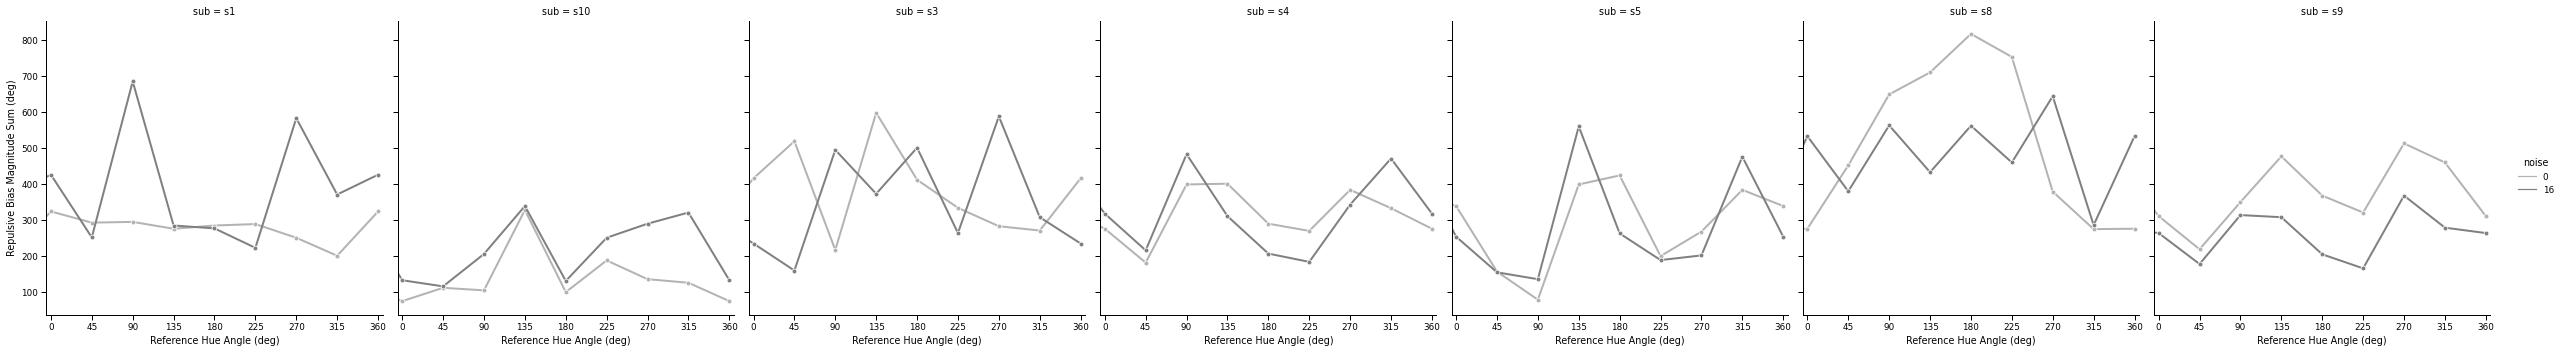

In [163]:
g = sns.relplot(data=fill_gap(rb_summary).reset_index().sort_values(by='sub'), x='ref', y='sum', hue='noise', ci=68, col='sub', 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]),  marker="o")

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Sum (deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])

/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


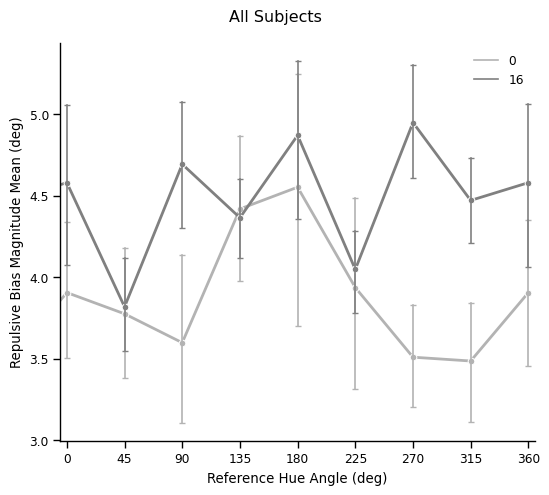

In [75]:
g = sns.relplot(data=fill_gap(rb_summary).reset_index().sort_values(by='sub'), x='ref', y='mean',  ci=68, hue='noise', 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, palette=sns.color_palette(noise_palette[0:2]), marker="o")

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Mean (deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])

plt.suptitle('All Subjects')
g.legend.remove()
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()


/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['ref'] = first['ref'].apply(lambda x: x + 360)
/var/folders/zv/khq8d7tn67v0nskb9lqcwxj00000gn/T/ipykernel_4164/1575399625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['ref'] = last['ref'].apply(lambda x: x - 360)


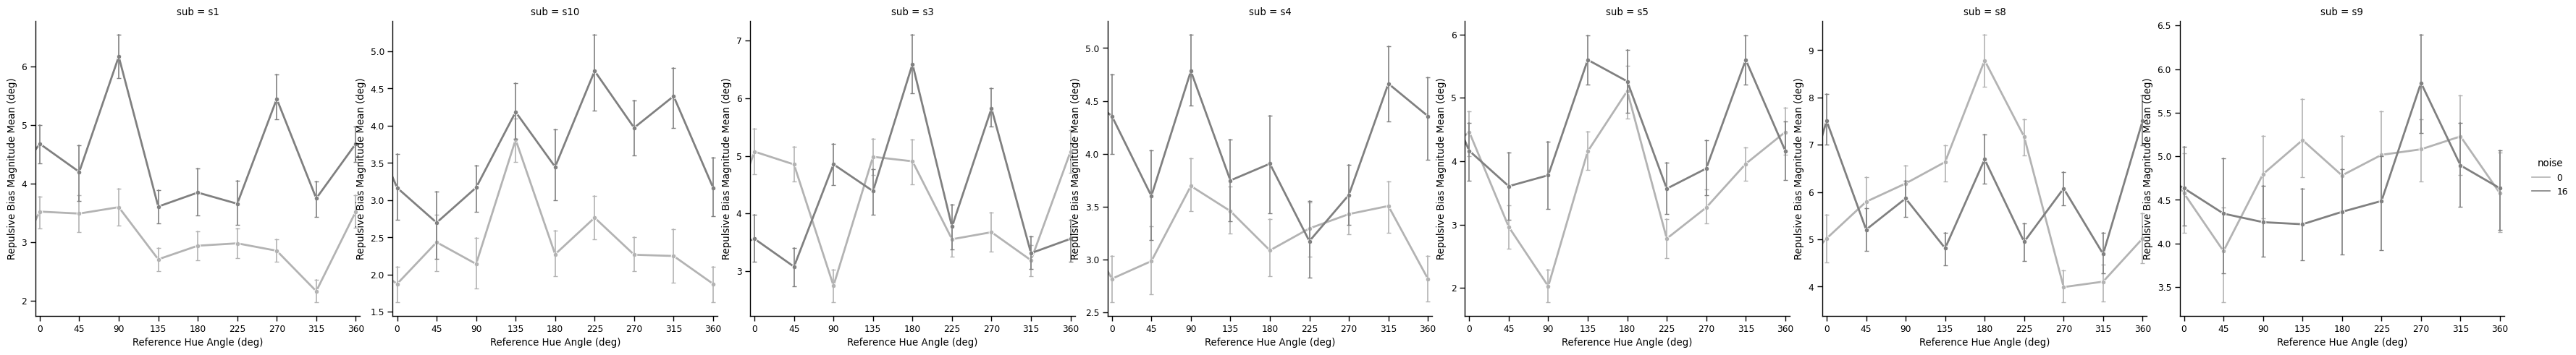

In [76]:
# Column by subject
g = sns.relplot(data=fill_gap(sel_dat_correct).reset_index().sort_values(by='sub'), x='ref', y='repulsive_bias', hue='noise', ci=68, col='sub', 
            kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, facet_kws={'sharey':False}, palette=sns.color_palette(noise_palette[0:2]),  marker="o")

# Pooled data
# g = sns.relplot(data=fill_gap(sel_dat_correct).reset_index().sort_values(by='sub'), x='ref', y='repulsive_bias', hue='noise', ci=68, 
#             kind='line', linewidth=2, err_style="bars", err_kws={'capsize': 2.}, facet_kws={'sharey':False}, palette=sns.color_palette(noise_palette[0:2]),  marker="o")

g.set(xlabel='Reference Hue Angle (deg)', ylabel='Repulsive Bias Magnitude Mean (deg)')
g.set(xticks=np.arange(0, 360+45, 45))
g.set(xlim=[-5, 365])

# 6.0. Baseline Analysis

## Different codes for baseline data

In [ ]:
dat_baseline = dat[dat.task_type==0]  # make sure you are analyzing baseline data
dat_baseline_correct = dat_baseline[dat_baseline.resp_correct == 1]

In [ ]:
# Plot mean estimates

fig, ax = plt.subplots(figsize=(5, 6), )
ax.plot(np.linspace(-15, 15, 50), np.linspace(-15, 15, 50), linestyle='--', color='gray')
sns.lineplot(data=dat_baseline_correct.query("relative_response >= 0"), 
            x='relative_stimulus', y='relative_response', hue='sub', linewidth=1.5, ci=68, ax=ax)
sns.lineplot(data=dat_baseline_correct.query("relative_response <= 0"), 
                x='relative_stimulus', y='relative_response', hue='sub', linewidth=1.5, ci=68, ax=ax, legend=False)
ax.set_ylim([-25, 25])
ax.set_xlabel('Stimulus Hue Angle (deg)')
ax.set_ylabel('Estimated Hue Angle (deg)')

plt.tight_layout()
plt.suptitle(f"Baseline: Mean Estimates of Correct Trials ({len(dat_baseline_correct)} of {len(dat_baseline)})", x=0.5, y=1.05)

# plt.savefig("")

plt.plot()

In [ ]:
# Plot repulsive bias

# palette = {k:colorcode[k] for k in [45, 135, 225, 315]}
palette = {k:colorcode[k] for k in [0, 45, 90, 135, 180, 225, 270, 315]} # can be used for 8 colors

# compute repulsive bias
dat_baseline_correct['repulsive_bias'] = np.where(dat_baseline_correct.relative_stimulus * dat_baseline_correct.bias < 0, 
                                                -abs(dat_baseline_correct['bias']), abs(dat_baseline_correct['bias']))


g = sns.relplot(data=dat_baseline_correct, x='abs_relative_stimulus', y='repulsive_bias',  
                col='sub', hue='ref',row='task_type', facet_kws={'sharey': True, 'sharex': True},
                kind='line', linewidth=2, palette=palette, ci=68, err_style="bars", err_kws={'capsize': 2.})
g.map(plt.axhline, y=0, color='gray', linestyle='dashed')
g.set(xlabel='Stimulus Hue Angle (absolute, deg)', ylabel='Repulsive Bias (deg)')
plt.suptitle(f"Baseline: Repulsive Bias of Correct Trials ({len(dat_baseline_correct)} of {len(dat_baseline)})", x=0.5, y=1.05)

#plt.savefig('pilot_figures/combined/combined_fig5.pdf')


In [ ]:
# Plot repulsive bias

# compute repulsive bias
dat_resp_correct['repulsive_bias'] = np.where(dat_resp_correct.relative_stimulus * dat_resp_correct.bias < 0, 
                                                -abs(dat_resp_correct['bias']), abs(dat_resp_correct['bias']))

g = sns.relplot(data=dat_resp_correct, x='abs_relative_stimulus', y='repulsive_bias',  
                col='sub', hue='task_type', facet_kws={'sharey': True, 'sharex': True},
                kind='line', linewidth=2, palette='colorblind', ci=68, err_style="bars", err_kws={'capsize': 2.})
g.map(plt.axhline, y=0, color='gray', linestyle='dashed')
g.set(xlabel='Stimulus Hue Angle (absolute, deg)', ylabel='Repulsive Bias (deg)')
plt.suptitle(f"Repulsive Bias of Correct Trials", x=0.5, y=1.05)

#plt.savefig("".pdf")
plt.plot()


## Compare baseline vs. test conditions

In [ ]:
# make sure we have both baseline and test conditions, also be careful about noises
# for example, dat should be read from 'pilot_data/pilot_all.csv'

# select only one noise level, such as 10
dat = dat[dat.noise == 10]

# select trials with correct responses
dat_resp_correct = dat[dat.resp_correct == 1]
pd.pivot_table(data=dat_resp_correct, values='response', index='sub', columns=['task_type', 'noise'],  aggfunc='count')

In [ ]:
# Plot mean estimates
subs = dat['sub'].unique()

fig, axes = plt.subplots(figsize=(5*len(subs), 6), ncols=len(subs))
for s, ax in zip(subs, axes):
    dat_resp_correct_s = dat_resp_correct[dat_resp_correct['sub'] == s]
    dat_s = dat[dat['sub'] == s]
    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='gray')
    sns.lineplot(data=dat_resp_correct_s.query("relative_response >= 0"), 
                x='relative_stimulus', y='relative_response',  hue='task_type', palette='colorblind', 
                linewidth=1.5, ci=68, ax=ax)
    sns.lineplot(data=dat_resp_correct_s.query("relative_response <= 0"), 
                    x='relative_stimulus', y='relative_response', hue='task_type', palette='colorblind', 
                    linewidth=1.5, ci=68, ax=ax, legend=False)
    ax.set_title(f"{s}")
    ax.set_ylim([-25, 25])
    ax.set_xlabel('Stimulus Hue Angle (deg)')
    ax.set_ylabel('Estimated Hue Angle (deg)')

plt.tight_layout()
plt.suptitle(f"Mean Estimates of Correct Trials", x=0.5, y=1.05)

# plt.savefig(".pdf")

plt.plot()

# ===== Under Construction ====== #

# tmp analysis on noise levels

In [ ]:
# s_0noise = pd.concat([LoadData(sub = 's4', data_path='test_data', sel_par=['params_hard_pair'], sel_ses='20220405', sel_ses_idx=[1, 2, 3]).read_data(), 
#                 LoadData(sub = 's4', data_path='test_data', sel_par=['params_hard_pair'], sel_ses='20220407', sel_ses_idx=[1]).read_data()], ignore_index=True)

s_0noise = pd.concat([LoadData(sub = 's5', data_path='test_data', sel_par=['params_hard_pair'], sel_ses='20220405', sel_ses_idx=[1, 2, 3]).read_data(), 
                LoadData(sub = 's5', data_path='test_data', sel_par=['params_hard_pair'], sel_ses='20220407',  sel_ses_idx=[1]).read_data()], ignore_index=True)

s_0noise = s_0noise.query("discard_this_trial == False")   

s_0noise['noise'] = 0

# s_0noise['sub'] = 's3'

s_0noise.head()

In [ ]:
# s_10noise = LoadData(sub = 's4', data_path='pilot_data', sel_par=['noise10'], sel_ses_idx=[1, 2, 3, 4]).read_data()

s_10noise = LoadData(sub = 's3', data_path='pilot_data', sel_par=['noise10'], sel_ses_idx=[1, 2, 3, 4]).read_data()

s_10noise = s_10noise.query("discard_this_trial == False")   

s_10noise['noise'] = 10

s_10noise.head()

In [ ]:
# s_20noise = LoadData(sub = 's4', data_path='pilot_data', sel_par=['noise20'], sel_ses_idx=[1, 2, 3, 4]).read_data()

# s_20noise = s_20noise.query("discard_this_trial == False")   

# s_20noise['noise'] = 20

# s_20noise.head()

In [ ]:
# dat = pd.concat([s_0noise, s_10noise, s_20noise], ignore_index=True)
dat = pd.concat([s_0noise, s_10noise], ignore_index=True)

# dat = pd.read_csv('pilot_data/pilot_all.csv').query("sub == 's1' and task_type == 3")

dat['relative_response'] = dat['response'] - dat['ref']

In [ ]:
# `consistent` column represents whether judgment and reproduction are on the same left/right side
dat['consistent'] = False
dat.loc[(dat['right_to_ref']==0)&(dat['relative_response']<0),'consistent'] = True
dat.loc[(dat['right_to_ref']==1)&(dat['relative_response']>0),'consistent'] = True

# `abs_relative_stimulus` columns: absolute values of stimuli
dat['abs_relative_stimulus'] = dat.relative_stimulus.abs()

# `resp_correct` column represents whether responses are on the correct side
dat['resp_correct'] = True
dat.loc[dat.relative_stimulus * dat.relative_response < 0, 'resp_correct'] = False
dat.loc[(dat.relative_stimulus != 0) & (dat.relative_response == 0), 'resp_correct'] = False

# dat.to_csv('pilot_data/s3_noise_2_cons.csv', index=False)

pd.pivot_table(data=dat, values='response', index='relative_stimulus', columns=['task_type', 'noise'],  aggfunc='count')


In [ ]:
# for different noise conditions

n_stim = len(dat['relative_stimulus'].unique())
noises = dat['noise'].sort_values().unique()


fig, axes = plt.subplots(1, len(noises), figsize=[5*len(noises) + 0.5, 6*1])

for idx, ax in enumerate(axes.flatten()):
    # filter data with this reference
    noise = noises[idx]
    vals = dat[dat.noise==noise]
    hh, xedges, yedges = np.histogram2d(vals.relative_stimulus.values, vals.relative_response.values, bins=[n_stim, 90], normed=True)
    im = ax.imshow(hh.T, interpolation='nearest', origin='lower', cmap='gray', 
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
    cb = fig.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))

    ax.plot(np.linspace(-18, 18, 50), np.linspace(-18, 18, 50), linestyle='--', color='coral')
    sns.lineplot(ax=ax, data=vals, x='relative_stimulus', y='relative_response', ci=None, color='cyan', label='mean')
    ax.set_title(f"noise: {noise}")
    ax.set_xlabel('Stimulus Orientation (deg)')
    ax.set_ylabel('Estimated Orientation (deg)')
    plt.suptitle(sub, y=1.05)

plt.tight_layout()
# plt.savefig('data_analysis/s6/heatmap_by_noise.pdf')
plt.plot()

In [ ]:
dat_correct_consistent = dat[(dat.ref_judge_correct == 1) & (dat.consistent == 1)]

fig, ax = plt.subplots(figsize=(5, 6), )

# choose what hue to use
hue = 'noise' 
# hue = 'sub' 

ax.plot(np.linspace(-15, 15, 50), np.linspace(-15, 15, 50), linestyle='--', color='gray')
sns.lineplot(data=dat_correct_consistent.query("relative_stimulus > 0"),
            x='relative_stimulus', y='relative_response', hue=hue, linewidth=1.5, ci=68, ax=ax)
sns.lineplot(data=dat_correct_consistent.query("relative_stimulus < 0"),
                x='relative_stimulus', y='relative_response', hue=hue, linewidth=1.5, ci=68, ax=ax, legend=False)
ax.set_ylim([-25, 25])
ax.set_xlabel('Stimulus Hue Angle (deg)')
ax.set_ylabel('Estimated Hue Angle (deg)')

plt.tight_layout()
plt.suptitle(f"Mean Estimates of Correct and Consistent Trials ({len(dat_correct_consistent)} of {len(dat)})", x=0.5, y=1.05)

# plt.savefig('data_analysis/s6/estimates_mean.pdf')

plt.plot()

In [ ]:
# plot repulsive bias

# palette = {k:colorcode[k] for k in [45, 135, 225, 315]}
palette = {k:colorcode[k] for k in [0, 45, 90, 135, 180, 225, 270, 315]} # can be used for 8 colors

# compute repulsive bias
dat['repulsive_bias'] = np.where(dat.relative_stimulus * dat.bias < 0, -abs(dat['bias']), abs(dat['bias']))

# select correct ones
dat_correct = dat[dat.ref_judge_correct == 1]

# col = 'sub' or 'noise' or 'task_type'
g = sns.relplot(data=dat_correct, x='abs_relative_stimulus', y='repulsive_bias', hue='noise', row='task_type', 
                facet_kws={'sharey': True, 'sharex': True},
                kind='line', linewidth=2, ci=68, err_style="bars", err_kws={'capsize': 2.})
g.map(plt.axhline, y=0, color='gray', linestyle='dashed')
plt.title(f"Repulsive Bias of Correct Trials ({len(dat_correct)} of {len(dat)})", x=0.5, y=1.05)
g.set(xlabel='Stimulus Hue Angle (absolute, deg)', ylabel='Repulsive Bias (deg)')

plt.tight_layout()
# plt.savefig('pilot_analysis/s4/repulsive_bias_by_noise.pdf')
plt.plot()